# **UTS DL Kelompok 3 - MODEL CNN**

- ALIF ALAMSYAH - 11220940000028
- IBNULLABIB - 11220940000037

## **Konfigurasi Awal: Random Seed dan Device**

In [ ]:
pip install torchinfo

In [ ]:
import torch # Mengimpor library utama PyTorch.
import torch.nn as nn # Mengimpor modul `neural network` dari PyTorch, biasanya di-alias sebagai `nn`.
import torch.nn.functional as F # Mengimpor fungsi-fungsi dalam `neural network` yang tidak memiliki parameter learnable, seperti fungsi aktivasi.
import torchvision # Mengimpor paket PyTorch yang khusus untuk Computer Vision.
import torchvision.transforms as transforms # Mengimpor modul `transforms` dari `torchvision` untuk melakukan augmentasi dan normalisasi gambar.
import torch.optim as optim # Mengimpor modul `optim` yang berisi algoritma optimasi seperti SGD, Adam, dll.
from torch.optim import lr_scheduler # Mengimpor `lr_scheduler` dari `torch.optim` untuk menyesuaikan learning rate selama training.
from torch.utils.data import DataLoader, random_split # Mengimpor `DataLoader` untuk memuat dataset secara batch dan `random_split` untuk membagi dataset.
import numpy as np # Mengimpor library NumPy untuk operasi numerik, terutama array.
import random # Mengimpor modul `random` bawaan Python untuk menghasilkan angka acak.
import os # Mengimpor modul `os` untuk berinteraksi dengan sistem operasi, seperti mengatur environment variable.
import matplotlib.pyplot as plt # Mengimpor `pyplot` dari Matplotlib untuk membuat plot atau visualisasi (meskipun tidak digunakan di snippet ini).
import time # Mengimpor modul `time` (meskipun tidak digunakan di snippet ini).
from torchinfo import summary # Mengimpor `summary` dari `torchinfo` untuk mencetak ringkasan arsitektur model.

def set_seed(seed_value): # Mendefinisikan sebuah fungsi bernama `set_seed` yang menerima satu argumen `seed_value`.
    """
    Mengatur seed untuk reproducibility di Python, NumPy, dan PyTorch.
    """
    random.seed(seed_value) # Mengatur seed untuk generator angka acak bawaan Python.
    np.random.seed(seed_value) # Mengatur seed untuk generator angka acak NumPy.
    torch.manual_seed(seed_value) # Mengatur seed untuk operasi random di CPU pada PyTorch.

    if torch.cuda.is_available(): # Mengecek apakah GPU dengan CUDA tersedia.
        torch.cuda.manual_seed(seed_value) # Mengatur seed untuk operasi random di GPU (current GPU) pada PyTorch.
        torch.cuda.manual_seed_all(seed_value) # Mengatur seed untuk operasi random di semua GPU yang tersedia pada PyTorch.
        torch.backends.cudnn.deterministic = True # Menginstruksikan cuDNN untuk menggunakan algoritma deterministik.
        torch.backends.cudnn.benchmark = False # Menonaktifkan fitur benchmark cuDNN yang dapat memilih algoritma non-deterministik untuk performa.
    os.environ['PYTHONHASHSEED'] = str(seed_value) # Mengatur seed untuk hashing di Python untuk beberapa operasi yang menggunakan hash.

# Panggil fungsi ini di awal skrip untuk memastikan hasil reproducible
set_seed(42) # Memanggil fungsi `set_seed` dengan nilai seed 42. Angka 42 adalah pilihan umum dan arbitrer.

# Tentukan penggunaan GPU jika tersedia, jika tidak, gunakan CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Membuat objek `device` yang akan menunjuk ke GPU pertama ("cuda:0") jika tersedia, jika tidak maka akan menunjuk ke CPU ("cpu").
print(f"Menggunakan device: {device}") # Mencetak device yang sedang digunakan (GPU atau CPU).


Menggunakan device: cuda:0


Kode di atas merupakan **tahap persiapan awal** sebelum  menjalankan proses *deep learning* dengan PyTorch. Ada tiga hal utama yang dilakukan:

1.  **Impor Pustaka Esensial**: kami memuat semua *library* dasar yang dibutuhkan untuk *deep learning* menggunakan PyTorch, seperti `torch` itu sendiri, `torch.nn` untuk membangun jaringan, `torchvision` untuk data gambar, dan `optim` untuk algoritma optimasi. Ini seperti menyiapkan semua alat sebelum bekerja.

2.  **Menjamin Hasil yang Konsisten (Reproducibility)**: kami membuat fungsi `set_seed` dan langsung menggunakannya (`set_seed(42)`). Tujuannya agar setiap kali kode ini dijalankan, hasil yang didapatkan akan selalu sama. Ini penting untuk validasi dan perbandingan. Fungsi ini mengatur "angka keberuntungan awal" (seed) untuk semua proses acak di Python, NumPy, dan PyTorch (baik di CPU maupun GPU, termasuk pengaturan spesifik untuk pustaka cuDNN).

3.  **Memilih Perangkat Komputasi Terbaik**: Kode secara otomatis mengecek apakah ada GPU (khususnya yang mendukung CUDA) yang bisa dipakai. Jika ada, PyTorch akan diarahkan untuk menggunakan GPU tersebut karena jauh lebih cepat untuk komputasi *deep learning*. Jika tidak ada, maka CPU yang akan digunakan.

Jadi, secara ringkas, kode ini menyiapkan lingkungan kerja kami agar stabil, hasilnya bisa diulang, dan menggunakan perangkat keras (GPU/CPU) seoptimal mungkin untuk tugas *deep learning* berikutnya.


## **Definisi Model CIFAR10NetWithFeatureMaps**

In [ ]:
# --- Modifikasi Model untuk Mendapatkan Feature Maps ---
class CIFAR10NetWithFeatureMaps(nn.Module): # Mendefinisikan kelas model baru bernama CIFAR10NetWithFeatureMaps, mewarisi dari nn.Module PyTorch
    def __init__(self, config): # Konstruktor kelas, menerima argumen 'config' (sebuah dictionary) untuk parameter model
        super(CIFAR10NetWithFeatureMaps, self).__init__() # Memanggil konstruktor dari kelas parent (nn.Module)
        conv_filters = config.get('conv_filters', [64, 128, 256]) # Mengambil jumlah filter untuk layer konvolusi dari config, default [64, 128, 256]
        kernel_size = config.get('kernel_size', 3) # Mengambil ukuran kernel dari config, default 3
        pool_type = config.get('pool_type', 'max') # Mengambil tipe pooling dari config, default 'max'
        fc_neurons = config.get('fc_neurons', 1024) # Mengambil jumlah neuron untuk fully connected layer dari config, default 1024
        dropout_rate = config.get('dropout_rate', 0.4) # Mengambil dropout rate dari config, default 0.4
        padding = kernel_size // 2 # Menghitung padding agar ukuran spasial output sama dengan input (same padding)

        # Layer Konvolusi Pertama
        self.conv1 = nn.Conv2d(3, conv_filters[0], kernel_size=kernel_size, padding=padding) # Layer konvolusi 2D: 3 channel input (RGB), conv_filters[0] output channels, ukuran kernel, padding
        self.bn1 = nn.BatchNorm2d(conv_filters[0]) # Layer Batch Normalization untuk menstabilkan dan mempercepat training setelah conv1

        # Layer Konvolusi Kedua
        self.conv2 = nn.Conv2d(conv_filters[0], conv_filters[1], kernel_size=kernel_size, padding=padding) # Layer konvolusi 2D: input dari conv1, conv_filters[1] output channels
        self.bn2 = nn.BatchNorm2d(conv_filters[1]) # Batch Normalization setelah conv2

        # Layer Konvolusi Ketiga
        self.conv3 = nn.Conv2d(conv_filters[1], conv_filters[2], kernel_size=kernel_size, padding=padding) # Layer konvolusi 2D: input dari conv2, conv_filters[2] output channels
        self.bn3 = nn.BatchNorm2d(conv_filters[2]) # Batch Normalization setelah conv3

        # Layer Pooling
        if pool_type == 'max': # Jika tipe pooling adalah 'max'
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Definisikan Max Pooling layer dengan kernel 2x2 dan stride 2 (mengurangi ukuran spasial jadi setengah)
        elif pool_type == 'avg': # Jika tipe pooling adalah 'avg'
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # Definisikan Average Pooling layer dengan kernel 2x2 dan stride 2
        else: # Jika tipe pooling tidak dikenali
            raise ValueError("pool_type harus 'max' atau 'avg'") # Tampilkan error

        # Menghitung jumlah fitur input untuk Fully Connected Layer pertama
        # Asumsi ukuran input gambar CIFAR-10 adalah 32x32. Setelah 3 kali pooling 2x2, ukuran menjadi 32 -> 16 -> 8 -> 4.
        # Jadi, ukuran feature map sebelum FC adalah conv_filters[2] x 4 x 4
        fc_input_features = conv_filters[2] * 4 * 4
        self.fc1 = nn.Linear(fc_input_features, fc_neurons) # Fully connected layer pertama: dari fc_input_features ke fc_neurons
        self.dropout = nn.Dropout(dropout_rate) # Layer Dropout untuk mencegah overfitting
        self.fc2 = nn.Linear(fc_neurons, 10) # Fully connected layer kedua (output layer): dari fc_neurons ke 10 kelas (untuk CIFAR-10)

    def forward(self, x): # Mendefinisikan alur maju (forward pass) dari model
        # Simpan feature maps setelah setiap layer konvolusi dan aktivasi
        feature_maps = {} # Inisialisasi dictionary kosong untuk menyimpan feature maps

        # Blok Konvolusi 1
        out_conv1 = F.relu(self.bn1(self.conv1(x))) # Konvolusi -> Batch Norm -> Aktivasi ReLU
        feature_maps['conv1'] = out_conv1 # Simpan output (feature map) dari blok conv1
        x_pooled1 = self.pool(out_conv1) # Pooling setelah blok conv1

        # Blok Konvolusi 2
        out_conv2 = F.relu(self.bn2(self.conv2(x_pooled1))) # Input dari pool1 -> Konvolusi -> Batch Norm -> Aktivasi ReLU
        feature_maps['conv2'] = out_conv2 # Simpan output (feature map) dari blok conv2
        x_pooled2 = self.pool(out_conv2) # Pooling setelah blok conv2

        # Blok Konvolusi 3
        out_conv3 = F.relu(self.bn3(self.conv3(x_pooled2))) # Input dari pool2 -> Konvolusi -> Batch Norm -> Aktivasi ReLU
        feature_maps['conv3'] = out_conv3 # Simpan output (feature map) dari blok conv3
        x_pooled3 = self.pool(out_conv3) # Pooling setelah blok conv3

        # Flattening dan Fully Connected Layers
        x_flattened = x_pooled3.view(-1, self.fc1.in_features) # Meratakan (flatten) output dari pooling terakhir agar bisa masuk ke FC layer
                                                               # -1 berarti ukuran batch diinferensi secara otomatis
        x_fc1 = F.relu(self.fc1(x_flattened)) # Input flattened -> FC1 -> Aktivasi ReLU
        x_dropout = self.dropout(x_fc1) # Terapkan dropout pada output FC1
        final_output = self.fc2(x_dropout) # Input dari dropout -> FC2 (menghasilkan logits untuk klasifikasi)
        return final_output, feature_maps # Kembalikan output akhir model dan dictionary feature maps

# --- Fungsi untuk Visualisasi Feature Maps ---
def visualize_feature_maps(feature_maps_dict, num_maps_to_show=8): # Mendefinisikan fungsi untuk visualisasi, menerima dictionary feature maps dan jumlah map yang ingin ditampilkan
    for layer_name, f_map_tensor in feature_maps_dict.items(): # Iterasi melalui setiap item (nama layer dan tensor feature map) dalam dictionary
        # Ambil feature maps dari batch pertama (jika batch > 1)
        f_map = f_map_tensor[0].cpu().detach().numpy() # Ambil data dari item pertama batch [0], pindahkan ke CPU, detach dari graph komputasi, konversi ke array NumPy
        num_features = f_map.shape[0] # Dapatkan jumlah feature maps (jumlah channel) pada layer tersebut

        plt.figure(figsize=(15, 15)) # Buat figure baru untuk plot dengan ukuran tertentu
        plt.suptitle(f'Feature Maps dari Layer: {layer_name}', fontsize=16) # Set judul utama untuk figure

        # Tampilkan beberapa feature map pertama
        maps_to_display = min(num_features, num_maps_to_show) # Tentukan jumlah map yang akan ditampilkan (minimum antara yang tersedia dan yang diminta)

        for i in range(maps_to_display): # Iterasi sebanyak maps_to_display
            plt.subplot(1, maps_to_display, i + 1) # Buat subplot (1 baris, maps_to_display kolom, plot ke-i+1)
            plt.imshow(f_map[i, :, :], cmap='viridis') # Tampilkan feature map ke-i dengan colormap 'viridis'
            plt.title(f'Map {i+1}') # Set judul untuk subplot
            plt.axis('off') # Matikan sumbu (axis)
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Sesuaikan layout agar rapi dan suptitle tidak tumpang tindih
        plt.show() # Tampilkan plot

print("Model CIFAR10NetWithFeatureMaps dan fungsi visualisasi telah didefinisikan.") # Cetak pesan konfirmasi

Model CIFAR10NetWithFeatureMaps dan fungsi visualisasi telah didefinisikan.


Pada dasarnya, kode ini bertujuan dua hal: pertama, **membangun sebuah model Jaringan Saraf Konvolusional (CNN) yang bisa kita "intip" cara kerjanya**, dan kedua, **membuat alat untuk menampilkan apa yang "dilihat" oleh model tersebut**.

### 1. Model CNN yang Transparan (`CIFAR10NetWithFeatureMaps`)

Kami mendefinisikan sebuah arsitektur CNN bernama `CIFAR10NetWithFeatureMaps`. Model ini dirancang untuk tugas klasifikasi gambar, khususnya untuk dataset CIFAR-10.

* **Desain Fleksibel**: Saat model ini dibuat, parameter utamanya (seperti jumlah filter pada lapisan konvolusi atau jumlah neuron) bisa diatur melalui sebuah `config`. Ini memudahkan eksperimen dengan berbagai variasi arsitektur.
* **Struktur Lapisan**:
    * Model ini memiliki beberapa **blok konvolusi**. Setiap blok terdiri dari lapisan konvolusi (`Conv2d`) untuk mencari pola atau fitur pada gambar, diikuti *Batch Normalization* (`BatchNorm2d`) untuk stabilitas pelatihan, aktivasi ReLU (`F.relu`) untuk memperkenalkan non-linearitas, dan lapisan *pooling* (`Pool`) untuk mereduksi ukuran fitur. Anggap saja setiap blok ini sebagai tahapan di mana model belajar mengenali aspek-aspek gambar yang semakin kompleks.
    * Setelah blok-blok konvolusi, terdapat **lapisan *fully connected*** (`Linear`) yang bertugas mengambil semua fitur yang telah dipelajari dan membuat keputusan akhir mengenai kelas gambar (misalnya, apakah gambar tersebut kucing, anjing, dst.). Ada juga lapisan *dropout* untuk mengurangi risiko *overfitting*.
* **Fitur Utama: Menyimpan "Jejak Belajar"**: Perbedaan krusial model ini adalah pada fungsi `forward`-nya (alur data maju). Setiap kali data gambar melewati sebuah blok konvolusi, output dari blok tersebut (yang disebut **_feature maps_** atau peta fitur) akan disimpan. _Feature maps_ ini merepresentasikan apa yang telah dipelajari atau dideteksi oleh model pada tahapan tersebut. Jadi, fungsi `forward` tidak hanya menghasilkan prediksi akhir, tetapi juga kumpulan _feature maps_ ini.

### 2. Visualisasi _Feature Maps_ (`visualize_feature_maps`)

Setelah mendapatkan _feature maps_ dari model, fungsi `visualize_feature_maps` ini digunakan untuk menampilkannya secara visual.

* **Tujuan**: Membantu kita memahami fitur visual apa yang diekstraksi oleh setiap lapisan konvolusi model.
* **Cara Kerja**:
    1.  Fungsi ini menerima kumpulan _feature maps_ yang telah disimpan oleh model.
    2.  Untuk setiap lapisan konvolusi yang _feature maps_-nya tersimpan, fungsi ini akan mengambil beberapa contoh _feature map_ (misalnya, 8 peta fitur pertama).
    3.  Kemudian, menggunakan `matplotlib`, setiap _feature map_ individual (yang pada dasarnya adalah gambar skala abu-abu atau berwarna semu) akan ditampilkan. Ini memungkinkan kita melihat, misalnya, apakah lapisan awal mendeteksi tepi atau tekstur sederhana, sementara lapisan yang lebih dalam mungkin mendeteksi bagian objek yang lebih kompleks.

---

**Intinya:**
Kode ini tidak hanya membuat model CNN untuk klasifikasi, tetapi juga memodifikasinya agar kita bisa "melihat ke dalam" dan memahami bagaimana model tersebut memproses gambar secara bertahap. Fungsi visualisasi kemudian membantu kita menerjemahkan "pemahaman internal" model tersebut menjadi gambar yang bisa kita interpretasikan. Ini adalah teknik yang sangat berguna dalam analisis dan _debugging_ model _deep learning_.

## **Persiapan Data**

In [ ]:
# Data Augmentation dan Normalisasi untuk training set
transform_train = transforms.Compose([ # Membuat serangkaian transformasi yang akan diterapkan secara berurutan pada data training.
    transforms.RandomCrop(32, padding=4), # Melakukan crop acak pada gambar ukuran 32x32 setelah menambahkan padding 4 piksel di setiap sisi. Ini membantu model menjadi lebih robust terhadap variasi posisi objek.
    transforms.RandomHorizontalFlip(), # Membalik gambar secara horizontal dengan probabilitas 0.5 (default). Ini adalah teknik augmentasi umum.
    transforms.ToTensor(), # Mengubah gambar PIL (Python Imaging Library) atau array NumPy menjadi tensor PyTorch. Juga mengubah skala nilai piksel dari [0, 255] menjadi [0.0, 1.0].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Menormalisasi tensor gambar dengan mean dan standard deviation yang diberikan untuk setiap channel (R, G, B). ((input - mean) / std). Ini mengubah rentang menjadi [-1, 1].
])

# Normalisasi untuk validation dan test set (tanpa augmentation)
transform_eval = transforms.Compose([ # Membuat serangkaian transformasi untuk data validasi dan test. Augmentasi biasanya tidak dilakukan di sini.
    transforms.ToTensor(), # Mengubah gambar menjadi tensor PyTorch dan menskalakan nilai piksel ke [0.0, 1.0].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Menormalisasi tensor gambar dengan mean dan std yang sama seperti pada training set.
])

# Mengunduh full training dataset
# Dataset ini akan digunakan sebagai basis untuk membuat training dan validation set.
# Transformasi augmentasi (transform_train) diterapkan di sini karena mayoritas akan menjadi data training.
full_trainset_for_split = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Mengunduh full training dataset lagi, tapi dengan transformasi evaluasi.
# Ini akan digunakan sebagai sumber untuk validation set, memastikan tidak ada augmentasi training pada data validasi.
full_val_set_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_eval)

# Memisahkan training set menjadi training dan validation set
val_size = int(0.1 * len(full_trainset_for_split)) # Menentukan ukuran validation set sebagai 10% dari total data training.
train_size = len(full_trainset_for_split) - val_size # Menentukan ukuran training set yang tersisa.

# random_split akan membuat dua subset secara acak berdasarkan indeks.
# Kita membagi urutan indeks dari 0 hingga panjang dataset.
train_indices, val_indices = random_split(range(len(full_trainset_for_split)), [train_size, val_size])

# Buat dataset aktual menggunakan indeks hasil random_split
# train_dataset akan mengambil sampel dari full_trainset_for_split (dengan augmentasi) menggunakan train_indices.
train_dataset = torch.utils.data.Subset(full_trainset_for_split, train_indices)
# val_dataset akan mengambil sampel dari full_val_set_raw (tanpa augmentasi training, hanya normalisasi) menggunakan val_indices.
val_dataset = torch.utils.data.Subset(full_val_set_raw, val_indices)

# Unduh dataset test
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_eval) # Mengunduh/memuat test set CIFAR-10. 'train=False' menandakan ini adalah test set. Transformasi evaluasi diterapkan.

# Nama-nama kelas
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Tuple yang berisi nama-nama kelas dalam dataset CIFAR-10, sesuai urutan labelnya.

print("Persiapan data selesai.") # Mencetak pesan konfirmasi bahwa proses persiapan data telah selesai.

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Persiapan data selesai.


Inti dari kode ini adalah **menyiapkan dataset gambar CIFAR-10** agar optimal untuk proses pelatihan dan evaluasi model *deep learning*. Ada beberapa langkah kunci:

### 1. "Memasak" Data Gambar (Transformasi)
Kami mendefinisikan dua cara untuk "memasak" atau mengubah gambar:

* **Untuk Data Pelatihan (`transform_train`)**:
    * **Variasi Buatan (Augmentasi)**: Gambar-gambar pelatihan sengaja diubah-ubah sedikit (dicrop acak, dibalik horizontal). Tujuannya agar model melihat lebih banyak variasi dan tidak kaku, sehingga bisa mengenali objek meskipun posisinya sedikit berbeda atau terbalik. Ini membantu model belajar lebih baik dan tidak *overfitting*.
    * **Standarisasi**: Gambar diubah menjadi format Tensor PyTorch dan nilai pikselnya dinormalisasi. Normalisasi ini seperti menyamakan "skala" data agar model lebih mudah belajar.

* **Untuk Data Evaluasi (`transform_eval` - Validasi & Tes)**:
    * **Tanpa Variasi Buatan**: Gambar untuk validasi dan tes **tidak** diubah-ubah dengan augmentasi. Kita ingin menguji model pada data yang "asli" atau apa adanya.
    * **Standarisasi**: Tetap dilakukan pengubahan ke Tensor dan normalisasi, sama seperti data pelatihan, agar perbandingannya adil.

### 2. Memuat dan Membagi Dataset
Dataset yang dipakai adalah CIFAR-10.

* **Pemisahan Cerdas untuk Pelatihan & Validasi**:
    1.  Awalnya, seluruh data yang akan dipakai untuk pelatihan dan validasi diunduh.
    2.  Data ini kemudian dibagi menjadi dua bagian: sebagian besar (90%) untuk **pelatihan aktual** dan sebagian kecil (10%) untuk **validasi** (semacam ujian kecil selama proses pelatihan).
    3.  **Poin Penting**: Saat pembagian, dipastikan bahwa data untuk **pelatihan aktual** diambil dari sumber yang sudah diterapkan augmentasi (`transform_train`). Sedangkan data untuk **validasi** diambil dari sumber yang hanya dinormalisasi (`transform_eval`), tanpa augmentasi pelatihan. Ini krusial agar proses validasi benar-benar mengukur kemampuan generalisasi model pada data yang "alami".

* **Data Tes**: Data tes diunduh secara terpisah dan hanya dikenai transformasi standar (`transform_eval`), karena ini adalah "ujian akhir" untuk model.

### 3. Label Kelas
Nama-nama kelas objek di CIFAR-10 (seperti 'pesawat', 'mobil', 'burung') disimpan untuk referensi.

---

**Secara Sederhana:**
Kode ini memastikan data gambar CIFAR-10 disiapkan dengan benar:
* **Data pelatihan diperbanyak variasinya** (dengan augmentasi) agar model lebih pintar.
* **Data validasi dan tes dijaga "kebersihannya"** (tanpa augmentasi pelatihan) agar hasil pengujian model benar-benar akurat dan bisa dipercaya.
* Semua data dinormalisasi agar proses matematis dalam pelatihan model berjalan lebih baik.

Tujuannya adalah menciptakan kondisi yang ideal untuk melatih model yang tangguh dan mengevaluasinya secara objektif.

## **Fungsi Pelatihan dan Evaluasi**

Fungsi ini sekarang akan *selalu* menyimpan model terbaik dari *setiap run* dan mengembalikan path-nya. Pengelolaan file (menghapus yang tidak terbaik) akan dilakukan di luar fungsi ini.

In [ ]:
def train_and_evaluate(config, train_dataset, val_dataset, testset, device): # Mendefinisikan fungsi untuk melatih dan mengevaluasi model
    """
    Melatih dan mengevaluasi model CNN dengan konfigurasi yang diberikan.
    Menyimpan model terbaik dari run ini dan mengembalikan path-nya.
    """
    print(f"\n--- Memulai Pelatihan dengan Konfigurasi ---") # Mencetak pesan awal bahwa pelatihan dengan konfigurasi tertentu dimulai
    print(config) # Mencetak konfigurasi yang digunakan untuk pelatihan ini
    start_time = time.time() # Mencatat waktu mulai pelatihan untuk menghitung durasi total

    # --- 1. Setup DataLoader ---
    batch_size = config.get('batch_size', 128) # Mengambil ukuran batch dari konfigurasi, default 128 jika tidak ada
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Membuat DataLoader untuk data latih, shuffle=True agar data diacak setiap epoch
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # Membuat DataLoader untuk data validasi, shuffle=False agar urutan evaluasi konsisten
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2) # Membuat DataLoader untuk data tes, shuffle=False

    # --- 2. Setup Model ---
    model = CIFAR10NetWithFeatureMaps(config).to(device) # Membuat instance model CIFAR10NetWithFeatureMaps dengan konfigurasi yang diberikan dan memindahkannya ke device (CPU/GPU)

    # --- 3. Setup Loss, Optimizer, Scheduler ---
    criterion = nn.CrossEntropyLoss() # Mendefinisikan fungsi loss Cross Entropy, umum digunakan untuk klasifikasi multi-kelas
    lr = config.get('learning_rate', 0.001) # Mengambil learning rate dari konfigurasi, default 0.001
    weight_decay = config.get('weight_decay', 0) # Mengambil parameter weight decay (L2 regularization) dari konfigurasi, default 0
    # PASTIKAN .lower() digunakan di sini
    optimizer_type = config.get('optimizer', 'Adam').lower() # Mengambil tipe optimizer dari konfigurasi, default 'Adam', dan mengubah ke huruf kecil untuk konsistensi

    # --- BAGIAN YANG DIPERBAIKI --- # Penanda bagian kode yang telah diperbaiki
    if optimizer_type == 'adam': # Jika tipe optimizer adalah 'adam'
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Menggunakan optimizer Adam
    elif optimizer_type == 'sgd': # Jika tipe optimizer adalah 'sgd'
        momentum = config.get('momentum', 0.9) # Mengambil parameter momentum untuk SGD, default 0.9
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) # Menggunakan optimizer SGD
    elif optimizer_type == 'rmsprop': # Jika tipe optimizer adalah 'rmsprop'
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay) # Menggunakan optimizer RMSprop
    else: # Jika tipe optimizer tidak dikenali
        # Pesan error yang lebih informatif
        raise ValueError(f"Optimizer '{config.get('optimizer')}' tidak dikenal. Pilih 'Adam', 'SGD', atau 'RMSprop'.") # Menampilkan pesan error
    # --- AKHIR BAGIAN YANG DIPERBAIKI --- # Penanda akhir bagian kode yang telah diperbaiki

    scheduler_step = config.get('scheduler_step', 20) # Mengambil langkah (epoch) untuk scheduler mengurangi learning rate, default 20
    scheduler_gamma = config.get('scheduler_gamma', 0.1) # Mengambil faktor pengali untuk mengurangi learning rate, default 0.1
    scheduler = lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma) # Mendefinisikan scheduler StepLR yang mengurangi lr secara berkala
    num_epochs = config.get('num_epochs', 75) # Mengambil jumlah epoch untuk pelatihan, default 75

    # --- 4. Loop Pelatihan ---
    best_val_accuracy = 0.0 # Inisialisasi akurasi validasi terbaik yang pernah dicapai
    epochs_no_improve = 0 # Inisialisasi counter untuk jumlah epoch tanpa peningkatan akurasi validasi (untuk early stopping)
    patience = config.get('patience', 15) # Mengambil parameter patience untuk early stopping, default 15 epoch
    train_losses, val_losses = [], [] # List untuk menyimpan loss training dan validasi per epoch
    train_accuracies, val_accuracies = [], [] # List untuk menyimpan akurasi training dan validasi per epoch
    config_hash = hash(frozenset(config.items())) # Membuat hash unik dari konfigurasi untuk nama file model
    model_save_path = f"best_model_{config_hash}_{int(time.time())}.pth" # Mendefinisikan path untuk menyimpan model terbaik, dengan hash konfigurasi dan timestamp

    print("Memulai pelatihan...") # Pesan bahwa loop pelatihan dimulai
    final_epoch = 0 # Variabel untuk mencatat epoch terakhir yang dijalankan (berguna jika ada early stopping)
    for epoch in range(num_epochs): # Loop utama untuk setiap epoch pelatihan
        final_epoch = epoch + 1 # Update epoch terakhir yang dijalankan
        model.train() # Mengatur model ke mode training (mengaktifkan dropout, batchnorm memperbarui statistik, dll.)
        running_loss, correct_train, total_train = 0.0, 0, 0 # Inisialisasi variabel untuk menghitung loss dan akurasi training epoch ini
        for i, data in enumerate(trainloader, 0): # Loop untuk setiap batch dalam data training
            inputs, labels = data[0].to(device), data[1].to(device) # Memindahkan input dan label ke device
            optimizer.zero_grad() # Mengosongkan gradien dari iterasi sebelumnya
            outputs, _ = model(inputs) # Melakukan forward pass. model mengembalikan (logits, feature_maps), feature_maps diabaikan di sini.
            loss = criterion(outputs, labels) # Menghitung loss
            loss.backward() # Melakukan backward pass untuk menghitung gradien
            optimizer.step() # Memperbarui bobot model berdasarkan gradien
            running_loss += loss.item() # Akumulasi loss training
            _, predicted = torch.max(outputs.data, 1) # Mendapatkan prediksi kelas
            total_train += labels.size(0) # Menghitung total sampel training yang diproses
            correct_train += (predicted == labels).sum().item() # Menghitung jumlah prediksi yang benar

        scheduler.step() # Memperbarui learning rate berdasarkan scheduler
        train_accuracy = 100 * correct_train / total_train # Menghitung akurasi training epoch ini
        train_losses.append(running_loss / len(trainloader)) # Menyimpan rata-rata loss training epoch ini
        train_accuracies.append(train_accuracy) # Menyimpan akurasi training epoch ini

        model.eval() # Mengatur model ke mode evaluasi (menonaktifkan dropout, batchnorm menggunakan statistik running)
        correct_val, total_val, val_loss = 0, 0, 0.0 # Inisialisasi variabel untuk menghitung loss dan akurasi validasi epoch ini
        with torch.no_grad(): # Menonaktifkan perhitungan gradien selama evaluasi
            for data in valloader: # Loop untuk setiap batch dalam data validasi
                images, labels = data[0].to(device), data[1].to(device) # Memindahkan input dan label ke device
                outputs, _ = model(images) # Melakukan forward pass. model mengembalikan (logits, feature_maps), feature_maps diabaikan.
                loss_val = criterion(outputs, labels) # Menghitung loss validasi
                val_loss += loss_val.item() # Akumulasi loss validasi
                _, predicted = torch.max(outputs.data, 1) # Mendapatkan prediksi kelas
                total_val += labels.size(0) # Menghitung total sampel validasi yang diproses
                correct_val += (predicted == labels).sum().item() # Menghitung jumlah prediksi yang benar

        val_accuracy = 100 * correct_val / total_val # Menghitung akurasi validasi epoch ini
        val_losses.append(val_loss / len(valloader)) # Menyimpan rata-rata loss validasi epoch ini
        val_accuracies.append(val_accuracy) # Menyimpan akurasi validasi epoch ini

        print(f'Epoch [{epoch + 1}/{num_epochs}], ' # Mencetak statistik epoch
              f'Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accuracy:.2f}%')

        if val_accuracy > best_val_accuracy: # Jika akurasi validasi saat ini lebih baik dari yang terbaik sebelumnya
            best_val_accuracy = val_accuracy # Perbarui akurasi validasi terbaik
            epochs_no_improve = 0 # Reset counter epoch tanpa peningkatan
            torch.save(model.state_dict(), model_save_path) # Simpan bobot model terbaik saat ini
        else: # Jika akurasi validasi tidak meningkat
            epochs_no_improve += 1 # Tambah counter epoch tanpa peningkatan

        if epochs_no_improve >= patience: # Jika counter epoch tanpa peningkatan mencapai batas patience
            print(f"Early stopping! Akurasi validasi tidak meningkat selama {patience} epoch.") # Cetak pesan early stopping
            break # Hentikan loop pelatihan

    print("Pelatihan Selesai!") # Cetak pesan bahwa pelatihan telah selesai
    training_time = time.time() - start_time # Hitung total waktu pelatihan

    # --- 5. Evaluasi Akhir ---
    print(f"Memuat model dari {model_save_path} untuk evaluasi akhir...") # Pesan bahwa model terbaik akan dimuat untuk evaluasi akhir
    try: # Blok try-except untuk menangani jika file model tidak ditemukan
        model.load_state_dict(torch.load(model_save_path)) # Muat bobot model terbaik yang disimpan
    except FileNotFoundError: # Jika file tidak ditemukan
        print(f"File {model_save_path} tidak ditemukan, menggunakan model terakhir.") # Cetak pesan dan gunakan model dari epoch terakhir (sebelum break jika ada early stopping)

    model.eval() # Atur model ke mode evaluasi
    correct_test, total_test = 0, 0 # Inisialisasi variabel untuk akurasi tes
    with torch.no_grad(): # Menonaktifkan perhitungan gradien
        for data in testloader: # Loop untuk setiap batch dalam data tes
            images, labels = data[0].to(device), data[1].to(device) # Pindahkan data tes ke device
            outputs, _ = model(images) # Lakukan forward pass. model mengembalikan (logits, feature_maps), feature_maps diabaikan.
            _, predicted = torch.max(outputs.data, 1) # Dapatkan prediksi
            total_test += labels.size(0) # Hitung total sampel tes
            correct_test += (predicted == labels).sum().item() # Hitung prediksi yang benar

    final_test_accuracy = 100 * correct_test / total_test # Hitung akurasi tes akhir
    print(f"Akurasi Test (Model Terbaik Run Ini): {final_test_accuracy:.2f}%") # Cetak akurasi tes

    # --- 6. Kembalikan Hasil (Termasuk Path Model) ---
    return { # Kembalikan dictionary yang berisi semua hasil dan informasi pelatihan
        "config": config, # Konfigurasi yang digunakan
        "best_val_accuracy": best_val_accuracy, # Akurasi validasi terbaik
        "final_test_accuracy": final_test_accuracy, # Akurasi tes akhir
        "train_losses": train_losses, # List loss training per epoch
        "val_losses": val_losses, # List loss validasi per epoch
        "train_accuracies": train_accuracies, # List akurasi training per epoch
        "val_accuracies": val_accuracies, # List akurasi validasi per epoch
        "training_time_seconds": training_time, # Total waktu pelatihan dalam detik
        "stopped_epoch": final_epoch, # Epoch di mana pelatihan berhenti
        "model_path": model_save_path # Path ke file model terbaik yang disimpan
    }

Fungsi `train_and_evaluate` ini adalah **mesin otomatis untuk melatih dan menguji model *deep learning* kita dari awal hingga akhir.**

Proses utamanya begini:

1.  **Persiapan**: Semua yang dibutuhkan disiapkan—data dibagi per porsi, model dibangun, dan alat bantu untuk belajar (seperti pengukur kesalahan dan metode koreksi) ditentukan.

2.  **Pelatihan Inti**:
    * Model belajar dari data latih secara berulang-ulang (*epoch*).
    * Setiap selesai satu putaran belajar, kemampuannya langsung dicek menggunakan data validasi.
    * Versi model yang paling baik selama proses ini disimpan. Jika model tidak menunjukkan kemajuan lagi, proses belajar dihentikan lebih awal (*early stopping*).

3.  **Tes Akhir**: Model terbaik yang disimpan tadi, kemudian diuji performanya menggunakan data tes yang benar-benar baru.

4.  **Pelaporan**: Semua hasil penting—seperti akurasi, waktu pelatihan, dan konfigurasi yang dipakai—dicatat dan dikembalikan sebagai laporan.

---

Intinya, fungsi ini menjalankan seluruh eksperimen: melatih model secara cerdas, mengevaluasinya, dan melaporkan hasilnya secara terstruktur.

## **Menjalankan Eksperimen Tuning**

Sekarang menjalankan *semua* konfigurasi, menggunakan 75 epoch, dan mengelola file model yang disimpan.

In [ ]:
# --- Definisikan Konfigurasi untuk Eksperimen ---

config1 = { # Mendefinisikan dictionary pertama untuk konfigurasi hyperparameter.
    "conv_filters": (64, 128, 256), # Jumlah filter untuk layer konvolusi (sebagai tuple).
    "kernel_size": 3, # Ukuran kernel untuk konvolusi.
    "pool_type": "max", # Jenis pooling layer (max pooling).
    "fc_neurons": 1024, # Jumlah neuron di fully connected layer.
    "dropout_rate": 0.3, # Rate untuk dropout.
    "batch_size": 128, # Ukuran batch untuk training.
    "learning_rate": 0.001, # Learning rate awal.
    "optimizer": "Adam", # Jenis optimizer yang akan digunakan.
    "weight_decay": 1e-4, # Nilai weight decay (L2 regularization).
    "num_epochs": 75, # Jumlah maksimum epoch untuk pelatihan.
    "patience": 15, # Jumlah epoch untuk early stopping jika tidak ada peningkatan.
    "scheduler_step": 25 # Jumlah epoch sebelum learning rate di-update oleh scheduler.
}

config2 = { # Mendefinisikan dictionary kedua untuk konfigurasi hyperparameter yang berbeda.
    "conv_filters": (128, 256, 512), # Jumlah filter lebih banyak.
    "kernel_size": 3,
    "pool_type": "max",
    "fc_neurons": 512, # Neuron FC lebih sedikit.
    "dropout_rate": 0.5, # Dropout rate lebih tinggi.
    "batch_size": 64, # Batch size lebih kecil.
    "learning_rate": 0.01, # Learning rate lebih tinggi.
    "optimizer": "SGD", # Menggunakan optimizer SGD.
    "momentum": 0.9, # Momentum untuk SGD.
    "weight_decay": 5e-4, # Weight decay lebih tinggi.
    "num_epochs": 75,
    "patience": 15,
    "scheduler_step": 25
}

config3 = { # Mendefinisikan dictionary ketiga untuk konfigurasi hyperparameter lainnya.
    "conv_filters": (32, 64, 128), # Jumlah filter lebih sedikit.
    "kernel_size": 3,
    "pool_type": "avg", # Menggunakan average pooling.
    "fc_neurons": 1024,
    "dropout_rate": 0.4,
    "batch_size": 256, # Batch size lebih besar.
    "learning_rate": 0.0005, # Learning rate lebih rendah.
    "optimizer": "RMSprop", # Menggunakan optimizer RMSprop.
    "weight_decay": 0, # Tidak menggunakan weight decay.
    "num_epochs": 75,
    "patience": 15,
    "scheduler_step": 25
}

# --- Jalankan Semua Eksperimen ---
experiments_to_run = [config1, config2, config3] # Membuat list yang berisi semua dictionary konfigurasi yang akan dijalankan.

results_list = [] # Menginisialisasi list kosong untuk menyimpan hasil dari setiap eksperimen.

for config in experiments_to_run: # Melakukan iterasi melalui setiap konfigurasi dalam 'experiments_to_run'.
    # Asumsi fungsi set_seed, train_dataset, val_dataset, testset, device sudah didefinisikan sebelumnya
    set_seed(42) # Mengatur seed random generator untuk reproducibility sebelum setiap run pelatihan.
    results = train_and_evaluate(config, train_dataset, val_dataset, testset, device) # Memanggil fungsi train_and_evaluate dengan konfigurasi saat ini dan dataset yang ada.
    results_list.append(results) # Menambahkan dictionary hasil dari 'train_and_evaluate' ke 'results_list'.

# --- Tampilkan Ringkasan Hasil ---
print("\n\n--- Ringkasan Hasil Eksperimen ---") # Mencetak header untuk ringkasan hasil.
for res in results_list: # Melakukan iterasi melalui setiap item hasil dalam 'results_list'.
    print(f"Konfigurasi: {res['config']}") # Mencetak konfigurasi yang digunakan untuk hasil ini.
    print(f"  Akurasi Validasi Terbaik: {res['best_val_accuracy']:.2f}%") # Mencetak akurasi validasi terbaik yang dicapai.
    print(f"  Akurasi Tes Final: {res['final_test_accuracy']:.2f}%") # Mencetak akurasi tes final.
    print(f"  Waktu Pelatihan: {res['training_time_seconds']:.1f} detik") # Mencetak waktu pelatihan.
    print(f"  Path Model: {res['model_path']}") # Mencetak path tempat model disimpan.
    print("-" * 30) # Mencetak garis pemisah.

# --- Identifikasi dan Simpan Hasil Terbaik ---
# Menggunakan fungsi max() dengan key lambda untuk menemukan dictionary hasil dengan 'best_val_accuracy' tertinggi.
best_result = max(results_list, key=lambda x: x['best_val_accuracy'])
best_model_path = best_result['model_path'] # Mendapatkan path model dari hasil terbaik.

print(f"\nKonfigurasi Terbaik (berdasarkan Val Acc): {best_result['config']}") # Mencetak konfigurasi terbaik.
print(f"  Akurasi Tes: {best_result['final_test_accuracy']:.2f}%") # Mencetak akurasi tes dari konfigurasi terbaik.
print(f"  Model Terbaik Disimpan di: {best_model_path}") # Mencetak path model terbaik.

# --- Hapus Model yang Tidak Terbaik ---
# Asumsi modul 'os' sudah diimpor
for res in results_list: # Melakukan iterasi lagi melalui setiap item hasil.
    # Memeriksa apakah path model dari hasil saat ini BUKAN path model terbaik DAN apakah file model tersebut ada di disk.
    if res['model_path'] != best_model_path and os.path.exists(res['model_path']):
        print(f"Menghapus model: {res['model_path']}") # Mencetak pesan bahwa model akan dihapus.
        os.remove(res['model_path']) # Menghapus file model dari disk untuk menghemat ruang.


--- Memulai Pelatihan dengan Konfigurasi ---
{'conv_filters': (64, 128, 256), 'kernel_size': 3, 'pool_type': 'max', 'fc_neurons': 1024, 'dropout_rate': 0.3, 'batch_size': 128, 'learning_rate': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.0001, 'num_epochs': 75, 'patience': 15, 'scheduler_step': 25}
Memulai pelatihan...
Epoch [1/75], Train Loss: 1.614, Train Acc: 41.58%, Val Loss: 1.272, Val Acc: 53.26%
Epoch [2/75], Train Loss: 1.186, Train Acc: 57.15%, Val Loss: 0.950, Val Acc: 66.14%
Epoch [3/75], Train Loss: 1.019, Train Acc: 63.62%, Val Loss: 0.887, Val Acc: 67.84%
Epoch [4/75], Train Loss: 0.922, Train Acc: 67.44%, Val Loss: 0.803, Val Acc: 70.66%
Epoch [5/75], Train Loss: 0.856, Train Acc: 69.86%, Val Loss: 0.777, Val Acc: 72.38%
Epoch [6/75], Train Loss: 0.811, Train Acc: 71.69%, Val Loss: 0.720, Val Acc: 74.48%
Epoch [7/75], Train Loss: 0.764, Train Acc: 73.26%, Val Loss: 0.657, Val Acc: 76.96%
Epoch [8/75], Train Loss: 0.723, Train Acc: 74.79%, Val Loss: 0.619, Val Acc: 78.1

Kode ini adalah tentang **menjalankan beberapa eksperimen pelatihan model secara otomatis, lalu memilih yang terbaik.**

Prosesnya begini:

1.  **Siapkan Berbagai "Resep" (Konfigurasi)**: Kami membuat beberapa setelan atau "resep" berbeda (`config1`, `config2`, `config3`) untuk melatih model. Tiap "resep" punya kombinasi *hyperparameter* (seperti jumlah filter, *learning rate*, jenis *optimizer*) yang unik. Tujuannya adalah mencari tahu "resep" mana yang paling manjur.

2.  **Jalankan Setiap "Resep" (Eksperimen)**: Setiap "resep" ini kemudian dijalankan satu per satu untuk melatih model. Sebelum tiap percobaan, *random seed* diatur agar hasilnya bisa diulang dan adil. Semua hasil penting (seperti akurasi) dari tiap percobaan dicatat.

3.  **Tampilkan "Rapor" Setiap "Resep"**: Setelah semua percobaan selesai, ringkasan performa (akurasi validasi, akurasi tes, waktu, lokasi model) dari setiap "resep" ditampilkan.

4.  **Pilih "Resep Juara"**: Dari semua "resep" yang dicoba, kode akan otomatis memilih "resep" yang menghasilkan model dengan akurasi validasi tertinggi.

5.  **Bersih-Bersih**: Untuk menghemat ruang, hanya file model dari "resep juara" yang disimpan. Model-model lain yang performanya di bawah itu akan dihapus.

Intinya, ini adalah cara sistematis untuk mencoba banyak pendekatan berbeda dalam melatih model, lalu secara otomatis menemukan dan menyimpan pendekatan yang paling berhasil.

---
### **INTERPRETASI HASIL:**
Konfigurasi terbaik model CNN menghasilkan **akurasi validasi tertinggi** dengan pengaturan sebagai berikut:

* Tiga lapis **konvolusi** dengan filter: 128, 256, dan 512
* Ukuran kernel: 3, jenis pooling: **max pooling**
* Fully connected layer memiliki 512 neuron
* **Dropout 0.5** untuk mencegah overfitting
* **Batch size**: 64, **learning rate**: 0.01
* Optimizer: **Stochastic Gradient Descent** dengan momentum 0.9 dan weight decay 0.0005
* Dilatih selama maksimal 75 epoch, dengan **early stopping** jika tidak membaik selama 15 epoch
* Learning rate disesuaikan tiap 25 epoch

Hasil akhirnya, model ini mencapai:
*  Akurasi training: 93.10%
* Akurasi validasi: 89.46%
* Akurasi tes: 89.26%
Selisih akurasi train dan validasi/tess kecil, menandakan model **tidak overfitting** dan **mampu generalisasi dengan baik.**
Secara keseluruhan, model sudah **stabil dan cukup optimal** dalam melakukan klasifikasi.

## Menampilkan Ringkasan Model PyTorch

In [ ]:

model_path = best_model_path
best_config_fm = best_result['config'] # Mengambil konfigurasi model terbaik dari variabel 'best_result' (diasumsikan sudah ada)
model_fm = CIFAR10NetWithFeatureMaps(best_config_fm) # Membuat instance model CIFAR10NetWithFeatureMaps menggunakan konfigurasi terbaik
model_fm.load_state_dict(torch.load(best_model_path)) # Memuat bobot (weights) yang telah dilatih sebelumnya dari file yang ditunjuk oleh 'best_model_path' ke dalam model
model_fm.to(device) # Memindahkan model ke perangkat yang ditentukan (misalnya, GPU atau CPU)
model_fm.eval() # Mengatur model ke mode evaluasi. Ini penting karena menonaktifkan lapisan seperti Dropout dan mempengaruhi perilaku BatchNorm


try:
    # Cobalah untuk menggunakan model dari konteks sebelumnya jika ada
    if 'model_fm' in locals() and 'best_result' in locals():
        print("Menggunakan 'model_fm' yang sudah ada dan konfigurasinya.")
        model_to_summarize = model_fm # Gunakan model yang sudah di-load jika ada

    elif 'model_to_eval' in locals() and 'best_result' in locals():
        print("Menggunakan 'model_to_eval' yang sudah ada dan konfigurasinya.")
        model_to_summarize = model_to_eval
    else:

        print(f"PENTING: Anda perlu mendefinisikan kelas model dan konfigurasinya.")
        print(f"Kode berikut adalah placeholder dan kemungkinan besar GAGAL tanpa definisi yang benar.")

        raise ValueError("Definisi model atau konfigurasi tidak ditemukan. Silakan definisikan model Anda terlebih dahulu.")


    model_to_summarize.to(device)
    model_to_summarize.eval() # Set ke mode evaluasi


    input_size = (1, 3, 32, 32) # Ganti jika dataset berbeda (misal MNIST: (1, 1, 28, 28))

    print(f"\nModel Summary untuk {model_path} (menggunakan torchinfo):")
    # Parameter penting:
    # - model: instance model
    # - input_size: tuple ukuran input (batch_size, channels, height, width)
    # - col_names: kolom yang ingin ditampilkan (opsional)
    # - dtypes: jika ingin menampilkan tipe data per layer (opsional)
    summary(model_to_summarize,
            input_size=input_size,
            col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
            verbose=1) # verbose=0 untuk lebih ringkas, verbose=1 untuk standar, verbose=2 untuk lebih detail

except Exception as e:
    print(f"Terjadi kesalahan: {e}")
    print("Pastikan Anda telah mendefinisikan kelas model dengan benar ('YourModelClass')")
    print("dan menyediakan parameter konfigurasi yang sesuai sebelum memuat state_dict.")
    print("File .pth biasanya hanya berisi weights, bukan arsitektur lengkap model.")

Menggunakan 'model_fm' yang sudah ada dan konfigurasinya.

Model Summary untuk best_model_-6571520221777023546_1748965297.pth (menggunakan torchinfo):
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CIFAR10NetWithFeatureMaps                [1, 3, 32, 32]            [1, 10]                   --                        --                        --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 128, 32, 32]          3,584                     [3, 3]                    3,670,016
├─BatchNorm2d: 1-2                       [1, 128, 32, 32]          [1, 128, 32, 32]          256                       --                        256
├─MaxPool2d: 1-3                         [1, 128, 32, 32]          [1, 128, 16, 16]          --                        2                         --
├─Conv2d: 1-4                            [1, 128, 16, 16]          [1, 256, 16, 16]          2

#### **INTERPRETASI HASIL:**
* **Nama Model:** `CIFAR10NetWithFeatureMaps` (untuk dataset CIFAR-10 yang berisi gambar-gambar kecil).
* **Input:** Menerima 1 gambar berwarna (3 channel: Merah, Hijau, Biru) berukuran 32x32 piksel.
* **Output:** Menghasilkan 10 angka, yang biasanya mewakili probabilitas gambar tersebut termasuk dalam salah satu dari 10 kategori (misalnya: pesawat, mobil, burung, kucing, dll.).

**Perjalanan Data di Dalam Model (Lapisan demi Lapisan):**

Setiap baris menjelaskan satu "stasiun kerja" (lapisan) di pabrik ini:

1.  **`Conv2d` (Convolutional Layer):**
    * Ini adalah mata utama model. Lapisan ini memindai gambar dengan "filter" kecil untuk mencari pola (tepian, sudut, tekstur).
    * `1-1`: Gambar asli (3 channel) diubah menjadi 128 "peta fitur" baru. Ukurannya tetap 32x32. Butuh sekitar 3.5 ribu parameter (bobot yang dipelajari).
    * `1-4`: Peta fitur dari lapisan sebelumnya (128 peta, ukuran 16x16) diolah lagi menjadi 256 peta fitur. Butuh sekitar 295 ribu parameter.
    * `1-7`: Dari 256 peta fitur (ukuran 8x8) diolah menjadi 512 peta fitur. Butuh sekitar 1.18 juta parameter.
    * **`Kernel Shape [3,3]`**: Artinya filter yang digunakan berukuran 3x3 piksel.

2.  **`BatchNorm2d` (Batch Normalization):**
    * Setelah `Conv2d`, lapisan ini membantu menstabilkan dan mempercepat proses belajar model. Anggap saja seperti "kalibrasi" hasil dari lapisan `Conv2d`.
    * Jumlah parameternya kecil, hanya untuk mengatur normalisasi.

3.  **`MaxPool2d`:**
    * Lapisan ini "meringkas" informasi dengan mengambil nilai maksimum dari area kecil. Tujuannya untuk mengurangi ukuran peta fitur (misalnya dari 32x32 jadi 16x16) sambil mempertahankan fitur terpenting. Ini membuat model lebih efisien.
    * Tidak punya parameter untuk dipelajari.

    *Perhatikan polanya:* `Conv2d` -> `BatchNorm2d` -> `MaxPool2d`. Ini blok yang umum dalam arsitektur CNN. Model Ini menggunakan 3 blok seperti ini, di mana setiap bloknya:
    * Meningkatkan jumlah peta fitur (dari 3 ke 128, lalu ke 256, lalu ke 512).
    * Mengurangi ukuran spasial peta fitur (dari 32x32 ke 16x16, lalu ke 8x8, lalu ke 4x4).

4.  **`Linear` (Fully Connected Layer):**
    * Setelah semua proses "melihat" pola selesai dan ukuran data sudah cukup kecil (`[1, 512, 4, 4]`), data ini "diratakan" (flattened) menjadi satu vektor panjang (`1 * 512 * 4 * 4 = 8192` angka).
    * `1-10`: Vektor panjang `[1, 8192]` ini kemudian dihubungkan ke 512 neuron. Ini adalah lapisan "pengambilan keputusan" awal berdasarkan fitur yang telah diekstrak. Punya banyak parameter (sekitar 4.19 juta).
    * `1-12`: Dari 512 neuron tadi, dihubungkan lagi ke 10 neuron output akhir. Ini adalah keputusan final model untuk 10 kelas.

5.  **`Dropout`:**
    * `1-11`: Selama training, lapisan ini secara acak "mematikan" beberapa neuron. Ini teknik untuk mencegah model terlalu menghafal data training (overfitting) dan membuatnya lebih general. Tidak punya parameter.

**Tambahan:**

* **`Total params: 5,680,650`**: Total ada sekitar 5,68 juta "kenop" atau parameter yang bisa diatur (dipelajari) oleh model selama proses training. Semuanya bisa dilatih (`Trainable params`).
* **`Total mult-adds (Units.MEGABYTES): 158.97`**: Ini ukuran seberapa banyak komputasi (operasi perkalian-penjumlahan) yang dibutuhkan model untuk satu kali memproses gambar. Angka ini menunjukkan model ini cukup intensif secara komputasi. Semakin besar, semakin berat kerjanya.
* **`Input size (MB): 0.01`**: Ukuran gambar input sangat kecil.
* **`Forward/backward pass size (MB): 3.67`**: Memori yang dibutuhkan selama proses training (untuk menyimpan aktivasi, gradien, dll.).
* **`Params size (MB): 22.72`**: Jika menyimpan model ini (bobot-bobotnya saja), ukurannya sekitar 22.72 MB.
* **`Estimated Total Size (MB): 26.41`**: Estimasi total memori yang dipakai model ini saat aktif di RAM/VRAM.


## **Plotting Loss dan Akurasi**

Plotting akan otomatis menggunakan `best_result` yang sudah diidentifikasi.

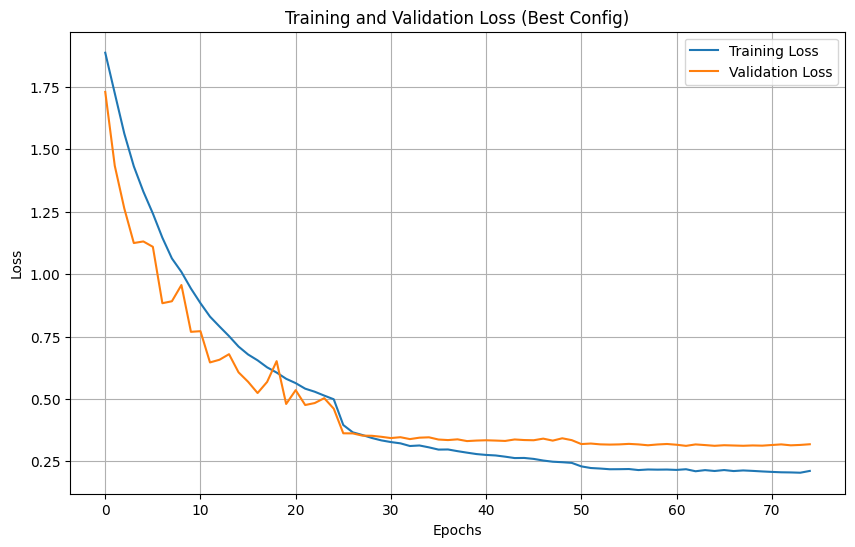

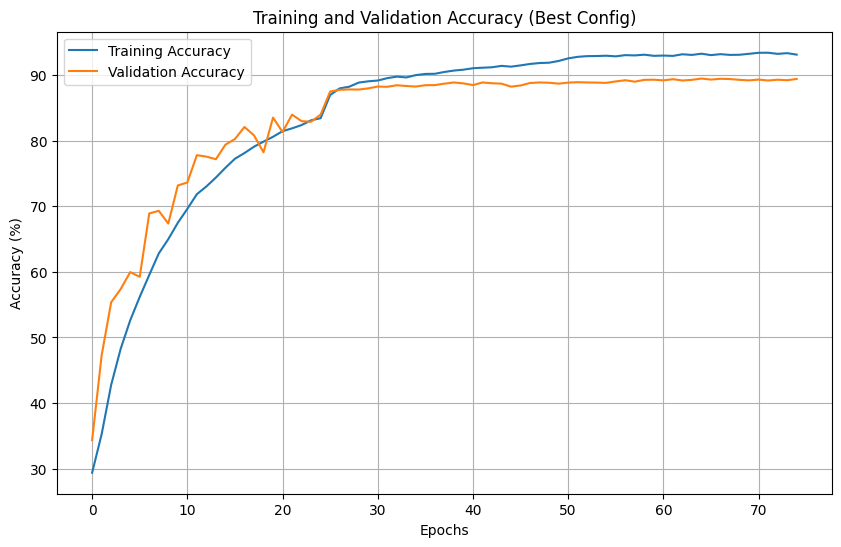

In [ ]:
import matplotlib.pyplot as plt # Mengimpor modul pyplot dari library matplotlib, yang umum digunakan untuk membuat plot statis, animasi, dan interaktif di Python. Diberi alias 'plt'.

# --- 6. Plotting Training and Validation Loss (dari Hasil Terbaik) ---
# Memastikan variabel 'best_result' tersedia dari eksekusi sel sebelumnya.
if 'best_result' in locals(): # Memeriksa apakah variabel 'best_result' ada dalam lingkup lokal saat ini. Ini untuk mencegah error jika sel sebelumnya belum dijalankan.
    train_losses = best_result['train_losses'] # Mengambil daftar (list) riwayat loss training dari dictionary 'best_result'.
    val_losses = best_result['val_losses'] # Mengambil daftar riwayat loss validasi dari dictionary 'best_result'.

    plt.figure(figsize=(10, 6)) # Membuat sebuah figure (wadah untuk plot) baru dengan ukuran 10x6 inci.
    plt.plot(train_losses, label='Training Loss') # Membuat plot garis untuk 'train_losses'. Sumbu x akan otomatis menjadi indeks (epoch), dan sumbu y adalah nilai loss. 'label' digunakan untuk legenda.
    plt.plot(val_losses, label='Validation Loss') # Membuat plot garis untuk 'val_losses' pada figure yang sama.
    plt.title(f'Training and Validation Loss (Best Config)') # Memberikan judul pada plot, mengindikasikan bahwa ini adalah loss dari konfigurasi terbaik.
    plt.xlabel('Epochs') # Memberikan label pada sumbu x sebagai 'Epochs'.
    plt.ylabel('Loss') # Memberikan label pada sumbu y sebagai 'Loss'.
    plt.legend() # Menampilkan legenda pada plot, yang akan menggunakan label yang didefinisikan di plt.plot().
    plt.grid(True) # Menambahkan grid pada plot untuk membantu pembacaan nilai.
    plt.show() # Menampilkan plot yang telah dibuat.

    # --- 7. Plotting Training and Validation Accuracy (dari Hasil Terbaik) ---
    train_accuracies = best_result['train_accuracies'] # Mengambil daftar riwayat akurasi training dari dictionary 'best_result'.
    val_accuracies = best_result['val_accuracies'] # Mengambil daftar riwayat akurasi validasi dari dictionary 'best_result'.

    plt.figure(figsize=(10, 6)) # Membuat figure baru untuk plot akurasi dengan ukuran 10x6 inci.
    plt.plot(train_accuracies, label='Training Accuracy') # Membuat plot garis untuk 'train_accuracies'.
    plt.plot(val_accuracies, label='Validation Accuracy') # Membuat plot garis untuk 'val_accuracies' pada figure yang sama.
    plt.title(f'Training and Validation Accuracy (Best Config)') # Memberikan judul pada plot akurasi.
    plt.xlabel('Epochs') # Memberikan label pada sumbu x sebagai 'Epochs'.
    plt.ylabel('Accuracy (%)') # Memberikan label pada sumbu y sebagai 'Accuracy (%)'.
    plt.legend() # Menampilkan legenda.
    plt.grid(True) # Menambahkan grid.
    plt.show() # Menampilkan plot akurasi.
else: # Jika variabel 'best_result' tidak ditemukan dalam lingkup lokal.
    print("Variable 'best_result' not found. Please run the previous cell first.") # Mencetak pesan error/peringatan.


### **Kegunaan Plot:**
* **Kurva Loss**: Idealnya, baik training loss maupun validation loss akan menurun seiring berjalannya epoch. Jika training loss terus menurun tetapi validation loss mulai meningkat, ini adalah tanda klasik dari *overfitting* (model terlalu menghafal data training dan tidak generalisasi dengan baik ke data baru). Jika kedua loss tetap tinggi, ini bisa menandakan *underfitting* (model terlalu sederhana atau belum cukup dilatih).
* **Kurva Akurasi**: Idealnya, baik training accuracy maupun validation accuracy akan meningkat. Jika training accuracy sangat tinggi tetapi validation accuracy jauh lebih rendah dan stagnan atau menurun, ini juga menunjukkan *overfitting*.



### **INTERPRETASI HASIL:**
#### **Kurva Loss:**

* **Training Loss** dan **Validation Loss** sama-sama menurun tajam di awal, lalu stabil di sekitar epoch ke-30.
* Validation loss cenderung **datarnya stabil**, tidak naik drastis, artinya **tidak terjadi overfitting**.
* Model belajar dengan baik dan **konvergen secara stabil**.

#### **Kurva Akurasi:**

* **Training Accuracy** dan **Validation Accuracy** meningkat konsisten, lalu sama-sama stabil setelah sekitar epoch ke-30.
* Tidak ada gap besar antara keduanya, yang menunjukkan model **generalize dengan baik**.
* Akurasi validasi mendekati akurasi training → **model cukup optimal dan tidak overfit**.

**Kesimpulan**: Model menunjukkan proses training yang **baik, stabil**, dan **tidak overfitting**, serta mampu mencapai **akselerasi dan akurasi yang tinggi**.


## **Evaluasi Rinci dan Visualisasi**

Sel-sel ini sekarang akan memuat model terbaik yang disimpan (`best_model_path`) dan menjalankannya.


Memuat model terbaik dari best_model_-6571520221777023546_1748965297.pth untuk evaluasi rinci...

--- Evaluasi Rinci per Kelas ---
Akurasi total pada test set (cek): 89.26%
Akurasi kelas plane     : 91.10%
Akurasi kelas car       : 94.50%
Akurasi kelas bird      : 85.60%
Akurasi kelas cat       : 79.40%
Akurasi kelas deer      : 89.80%
Akurasi kelas dog       : 82.10%
Akurasi kelas frog      : 92.20%
Akurasi kelas horse     : 90.40%
Akurasi kelas ship      : 93.70%
Akurasi kelas truck     : 93.80%

--- Visualisasi Prediksi ---


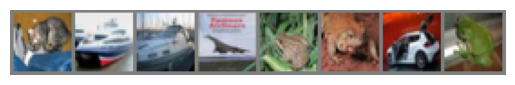

Label sebenarnya:  cat        ship       ship       plane      frog       frog       car        frog      
Prediksi model :  cat        ship       ship       plane      frog       frog       car        frog      


In [ ]:
import torch # Mengimpor library PyTorch
import torchvision # Mengimpor library torchvision yang berisi utilitas untuk computer vision
import numpy as np # Mengimpor library NumPy untuk operasi numerik, terutama untuk manipulasi array gambar
import matplotlib.pyplot as plt # Mengimpor pyplot dari Matplotlib untuk membuat plot dan visualisasi
from torch.utils.data import DataLoader # Mengimpor DataLoader dari PyTorch
# Diasumsikan CIFAR10NetWithFeatureMaps, best_model_path, best_result, device, testset, dan classes sudah didefinisikan

# --- Muat Model Terbaik untuk Evaluasi Rinci ---
print(f"\nMemuat model terbaik dari {best_model_path} untuk evaluasi rinci...") # Mencetak pesan bahwa model terbaik sedang dimuat
best_config = best_result['config'] # Mengambil konfigurasi dari hasil terbaik yang disimpan sebelumnya
model_to_eval = CIFAR10NetWithFeatureMaps(best_config) # Membuat instance model CIFAR10NetWithFeatureMaps dengan konfigurasi terbaik
model_to_eval.load_state_dict(torch.load(best_model_path)) # Memuat bobot (state dictionary) model yang telah dilatih dari file yang ditunjuk oleh best_model_path
model_to_eval.to(device) # Memindahkan model ke perangkat (CPU/GPU) yang ditentukan
model_to_eval.eval() # Mengatur model ke mode evaluasi (penting untuk batchnorm, dropout, dll.)

# Buat DataLoader dengan batch_size yang sesuai dari config terbaik
best_batch_size = best_config.get('batch_size', 128) # Mengambil ukuran batch dari konfigurasi terbaik, default 128
testloader_final = DataLoader(testset, batch_size=best_batch_size, shuffle=False, num_workers=2) # Membuat DataLoader untuk dataset tes, shuffle=False agar urutan konsisten


# --- 8. Evaluasi Rinci - Akurasi per Kelas ---

print("\n--- Evaluasi Rinci per Kelas ---") # Mencetak header untuk bagian evaluasi per kelas
class_correct = list(0. for i in range(10)) # Membuat list untuk menyimpan jumlah prediksi benar per kelas, diinisialisasi dengan 0 (untuk 10 kelas CIFAR-10)
class_total = list(0. for i in range(10)) # Membuat list untuk menyimpan jumlah total sampel per kelas, diinisialisasi dengan 0

with torch.no_grad(): # Blok konteks untuk menonaktifkan perhitungan gradien selama evaluasi
    for data in testloader_final: # Iterasi melalui setiap batch dalam testloader_final
        images, labels = data[0].to(device), data[1].to(device) # Memindahkan gambar dan label batch ke perangkat
        outputs, _ = model_to_eval(images) # Melakukan forward pass pada model. Model mengembalikan (logits, feature_maps), feature_maps diabaikan.
        _, predicted = torch.max(outputs, 1) # Mendapatkan kelas prediksi dengan mengambil indeks dari nilai output maksimum pada dimensi 1
        c = (predicted == labels).squeeze() # Membandingkan prediksi dengan label sebenarnya, menghasilkan tensor boolean. .squeeze() menghilangkan dimensi berukuran 1.
        # Perlu handle jika batch size = 1, squeeze akan menghilangkan dimensi batch
        if c.dim() == 0: # Jika tensor c menjadi skalar (0 dimensi) karena batch size = 1 dan disqueeze
            c = c.unsqueeze(0) # Tambahkan kembali dimensi batch agar konsisten untuk iterasi

        for i in range(len(labels)): # Iterasi melalui setiap sampel dalam batch saat ini
            label = labels[i] # Ambil label sebenarnya dari sampel ke-i
            class_correct[label] += c[i].item() # Jika prediksi benar (c[i] bernilai True/1), tambahkan 1 ke class_correct untuk label tersebut. .item() mengambil nilai Python dari tensor.
            class_total[label] += 1 # Tambahkan 1 ke class_total untuk label tersebut (menghitung total sampel untuk kelas ini)

# Cetak akurasi total (sebagai konfirmasi)
total_acc_check = 100 * sum(class_correct) / sum(class_total) # Menghitung akurasi total dari data per kelas
print(f'Akurasi total pada test set (cek): {total_acc_check:.2f}%') # Mencetak akurasi total sebagai pengecekan


for i in range(10): # Iterasi melalui setiap kelas (0 hingga 9 untuk CIFAR-10)
    if class_total[i] > 0: # Jika ada sampel untuk kelas ini
        accuracy = 100 * class_correct[i] / class_total[i] # Hitung akurasi untuk kelas ke-i
        print(f'Akurasi kelas {classes[i]:<10s}: {accuracy:.2f}%') # Cetak akurasi kelas (classes[i] adalah nama kelas, diformat rata kiri 10 karakter)
    else: # Jika tidak ada sampel untuk kelas ini (seharusnya tidak terjadi pada dataset tes standar)
        print(f'Akurasi kelas {classes[i]:<10s}: N/A (0 sampel)') # Cetak N/A


# --- 9. Visualisasi Prediksi Model ---

def imshow(img): # Mendefinisikan fungsi untuk menampilkan gambar tensor PyTorch
    """Fungsi untuk menampilkan gambar."""
    img = img / 2 + 0.5     # Unnormalize: Membalikkan normalisasi (jika gambar dinormalisasi ke range [-1, 1] dengan mean=0.5, std=0.5)
    npimg = img.numpy() # Mengonversi tensor gambar PyTorch ke array NumPy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Menampilkan gambar. np.transpose mengubah urutan dimensi dari (Channels, Height, Width) ke (Height, Width, Channels) yang diharapkan Matplotlib.
    plt.axis('off') # Menyembunyikan sumbu (axis) pada plot
    # plt.show() # Kita panggil show() sekali di akhir, jadi ini dikomentari

print("\n--- Visualisasi Prediksi ---") # Mencetak header untuk bagian visualisasi
dataiter = iter(testloader_final) # Membuat iterator dari testloader_final untuk mengambil satu batch data
try: # Blok try-except untuk menangani jika testloader kosong
    images, labels = next(dataiter) # Mengambil batch gambar dan label berikutnya dari iterator
except StopIteration: # Jika iterator sudah habis (testloader kosong)
    print("Test loader kosong.") # Cetak pesan
    images, labels = None, None # Atur images dan labels ke None untuk penanganan error

if images is not None: # Jika berhasil mendapatkan gambar dari data loader
    images_to_device = images.to(device) # Pindahkan batch gambar ke perangkat

    with torch.no_grad(): # Blok tanpa perhitungan gradien
        outputs, _ = model_to_eval(images_to_device) # Dapatkan output model. Sekali lagi, feature maps diabaikan.
        _, predicted = torch.max(outputs, 1) # Dapatkan prediksi kelas

    predicted = predicted.cpu() # Pindahkan tensor prediksi ke CPU untuk diproses lebih lanjut dengan NumPy/Matplotlib
    labels = labels.cpu() # Pindahkan tensor label ke CPU

    num_images_to_show = 8 # Jumlah gambar yang ingin ditampilkan dalam grid
    if len(images) < num_images_to_show: # Jika jumlah gambar dalam batch kurang dari yang ingin ditampilkan
        num_images_to_show = len(images) # Sesuaikan jumlah gambar yang akan ditampilkan

    img_grid = torchvision.utils.make_grid(images[:num_images_to_show]) # Membuat satu gambar grid dari beberapa gambar pertama dalam batch

    imshow(img_grid) # Panggil fungsi imshow untuk menyiapkan gambar grid untuk ditampilkan
    plt.show() # Tampilkan plot gambar grid sekarang

    print('Label sebenarnya: ', ' '.join(f'{classes[labels[j]]:<10s}' for j in range(num_images_to_show))) # Cetak label sebenarnya untuk gambar yang ditampilkan
    print('Prediksi model : ', ' '.join(f'{classes[predicted[j]]:<10s}' for j in range(num_images_to_show))) # Cetak label prediksi untuk gambar yang ditampilkan

### **INTERPRETASI HASIL:**

- **Akurasi Total**:

  * Akurasi keseluruhan pada test set adalah **89.26%**, menunjukkan model bekerja dengan **baik secara umum**.

- **Akurasi Per Kelas**:

  * Akurasi tertinggi: **car (94.50%)**, **truck (93.80%)**, dan **ship (93.70%)**.
  * Akurasi terendah: **cat (79.40%)** dan **dog (82.10%)**.
  * Artinya, model **lebih mudah mengenali objek seperti kendaraan** dibandingkan hewan seperti kucing dan anjing.

- **Visualisasi Prediksi**:

  * Gambar-gambar diuji dan semua **prediksi model sesuai dengan label aslinya**.
  * Ini menunjukkan bahwa model memiliki **kemampuan klasifikasi yang kuat secara visual**.

- **KESIMPULAN:**

Model bekerja **baik secara keseluruhan**, sangat akurat pada beberapa kelas, dan hasil prediksi pada sampel gambar juga **tepat**. Namun, **performa bisa ditingkatkan pada kelas yang lebih sulit dibedakan** seperti *cat* dan *dog*.


## Menampilkan Contoh Prediksi Model pada Gambar Uji

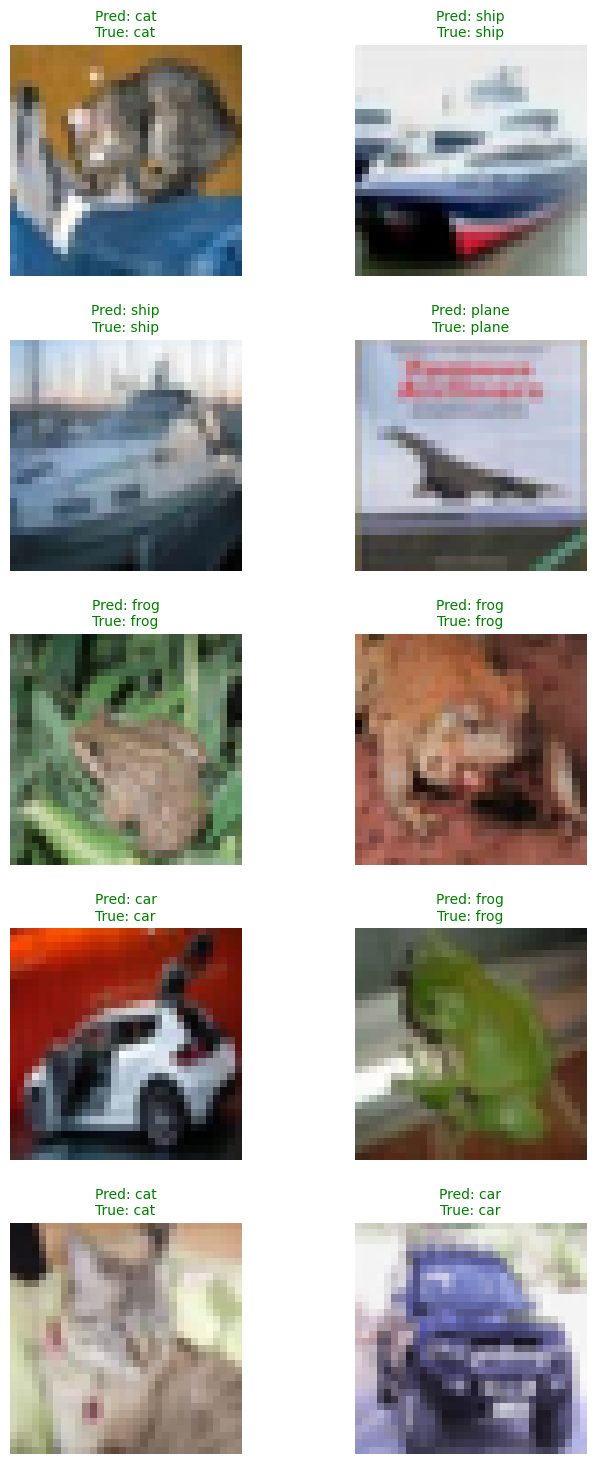

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader

# --- Asumsi variabel berikut sudah ada dari sel-sel sebelumnya:
# model_to_eval: model terbaik yang sudah di-load dan .eval()
# testloader_final: DataLoader untuk test set
# device: perangkat (cpu atau gpu)
# classes: tuple/list nama kelas ('plane', 'car', ...)
# imshow: fungsi untuk menampilkan gambar tensor

# --- Dapatkan satu batch gambar dari testloader untuk visualisasi ---
dataiter_vis = iter(testloader_final)
try:
    images_vis, labels_vis = next(dataiter_vis)
except StopIteration:
    print("Test loader visualisasi kosong atau sudah habis.")
    images_vis, labels_vis = None, None

if images_vis is not None:
    images_vis_device = images_vis.to(device)

    # --- Dapatkan prediksi model ---
    with torch.no_grad():
        outputs_vis, _ = model_to_eval(images_vis_device)
        _, predicted_vis = torch.max(outputs_vis, 1)

    # Pindahkan tensor ke CPU untuk plotting
    images_vis = images_vis.cpu()
    labels_vis = labels_vis.cpu()
    predicted_vis = predicted_vis.cpu()

    # --- Tampilkan 10 gambar dengan prediksi dan label sebenarnya ---
    num_images_to_display = 10
    if len(images_vis) < num_images_to_display:
        num_images_to_display = len(images_vis)

    fig = plt.figure(figsize=(8, 15)) # Sesuaikan ukuran figure jika perlu

    for i in range(num_images_to_display):
        ax = plt.subplot(5, 2, i + 1) # 5 baris, 2 kolom
        imshow(images_vis[i]) # imshow sudah menghandle unnormalization
        title_color = 'green' if predicted_vis[i] == labels_vis[i] else 'red'
        ax.set_title(f"Pred: {classes[predicted_vis[i].item()]}\nTrue: {classes[labels_vis[i].item()]}",
                     color=title_color, fontsize=10)
        ax.axis('off')

    plt.tight_layout(pad=2.0) # Menambahkan padding agar judul tidak tumpang tindih
    plt.show()

else:
    print("Tidak ada gambar untuk ditampilkan.")

## **Analisis Feature Maps pada Kesalahan Prediksi**

Memuat model terbaik dari best_model_-6571520221777023546_1748965297.pth untuk analisis feature maps...

Mencari gambar yang salah diklasifikasikan...
Gambar salah klasifikasi ditemukan.
  Label Sebenarnya: dog
  Prediksi Model  : deer


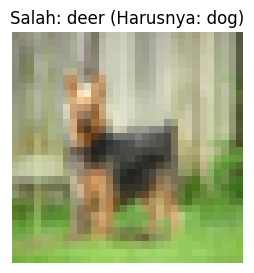


--- Feature Maps untuk Gambar yang Salah Klasifikasi ---


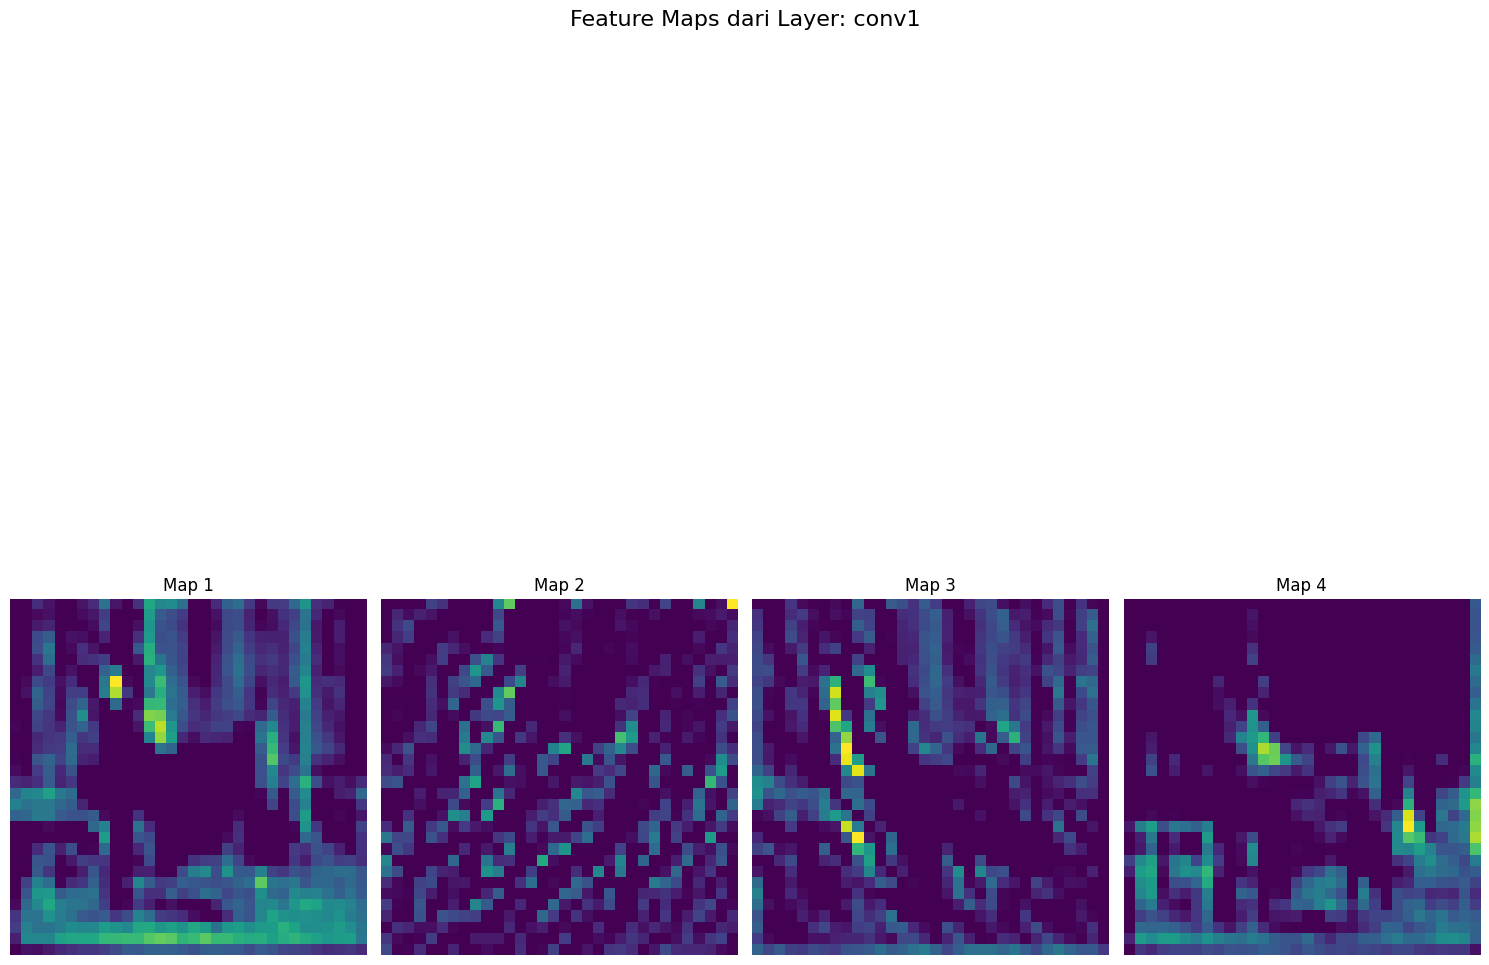

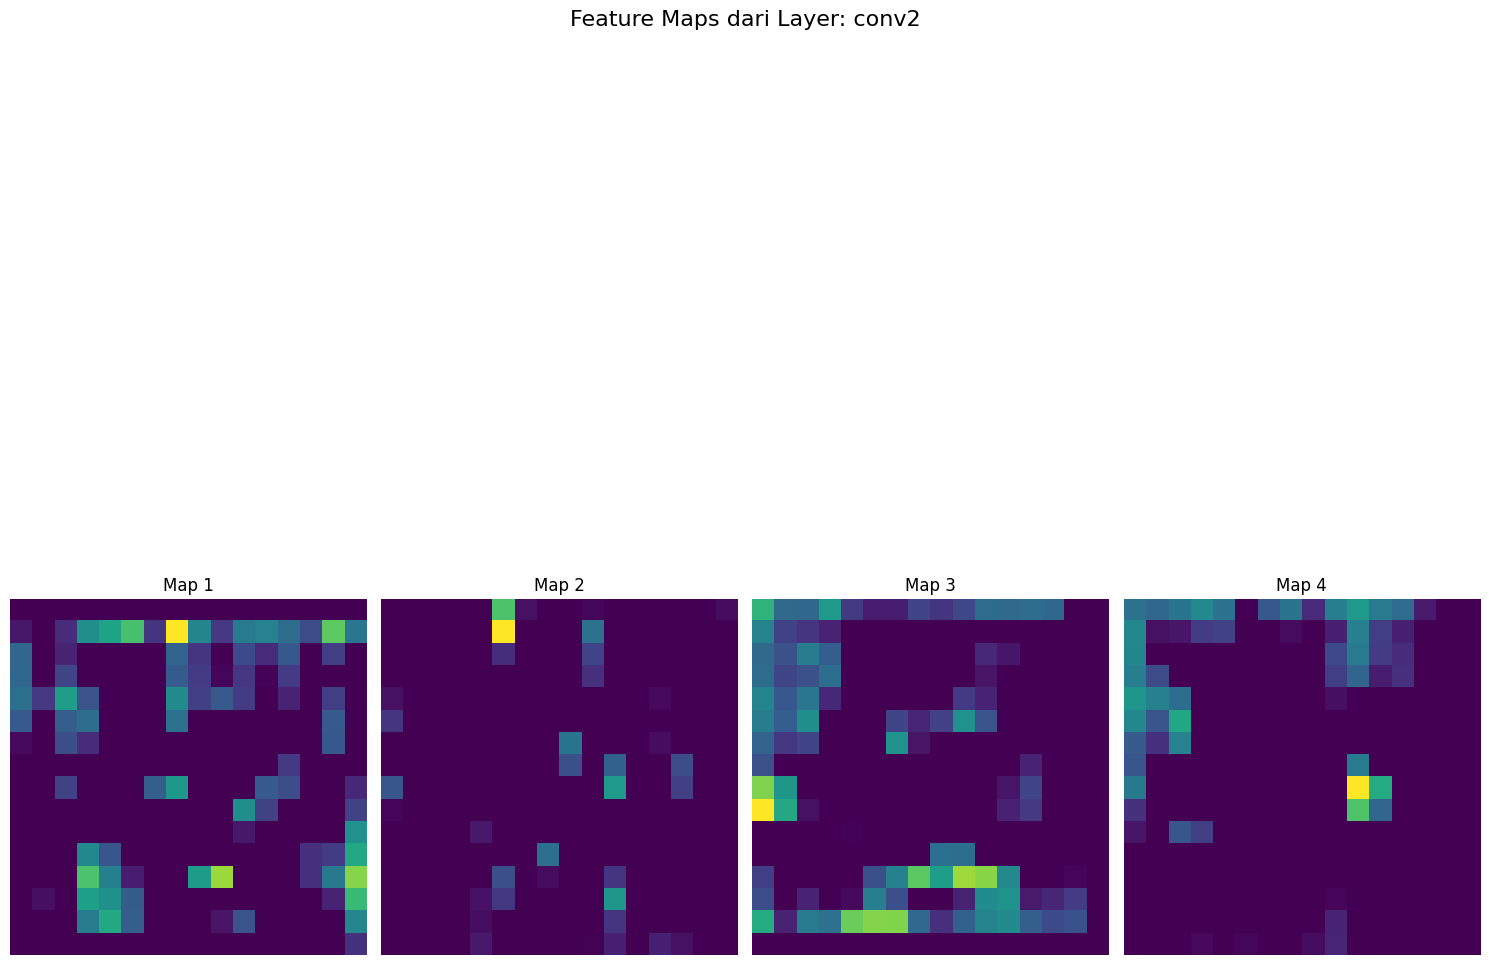

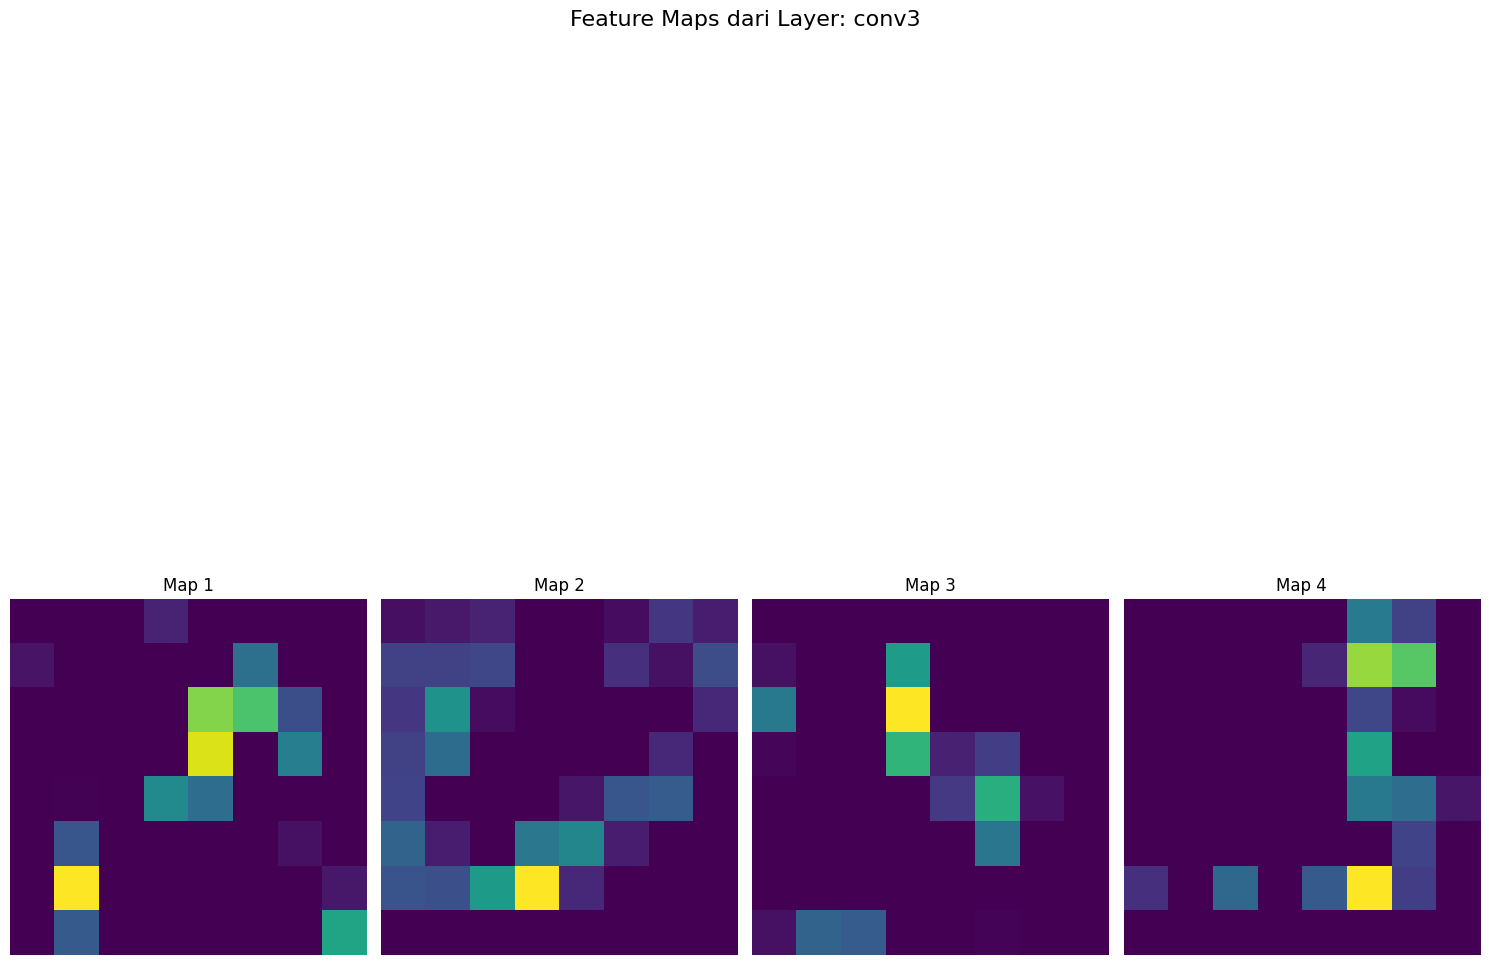

In [ ]:
# --- Muat Model Terbaik (versi dengan feature maps) ---
print(f"Memuat model terbaik dari {best_model_path} untuk analisis feature maps...") # Mencetak pesan informasi tentang pemuatan model
best_config_fm = best_result['config'] # Mengambil konfigurasi model terbaik dari variabel 'best_result' (diasumsikan sudah ada)
model_fm = CIFAR10NetWithFeatureMaps(best_config_fm) # Membuat instance model CIFAR10NetWithFeatureMaps menggunakan konfigurasi terbaik
model_fm.load_state_dict(torch.load(best_model_path)) # Memuat bobot (weights) yang telah dilatih sebelumnya dari file yang ditunjuk oleh 'best_model_path' ke dalam model
model_fm.to(device) # Memindahkan model ke perangkat yang ditentukan (misalnya, GPU atau CPU)
model_fm.eval() # Mengatur model ke mode evaluasi. Ini penting karena menonaktifkan lapisan seperti Dropout dan mempengaruhi perilaku BatchNorm

# --- Cari Gambar yang Salah Klasifikasi ---
misclassified_img = None # Variabel untuk menyimpan tensor gambar yang salah klasifikasi
misclassified_label_true = None # Variabel untuk menyimpan label sebenarnya dari gambar yang salah klasifikasi
misclassified_label_pred = None # Variabel untuk menyimpan label prediksi dari gambar yang salah klasifikasi

# Gunakan testloader_final yang sudah ada dari sel sebelumnya
# atau buat baru jika belum ada
if 'testloader_final' not in locals(): # Memeriksa apakah 'testloader_final' sudah ada di lingkup lokal variabel
     best_batch_size_fm = best_config_fm.get('batch_size', 128) # Mengambil ukuran batch dari konfigurasi terbaik, default 128 jika tidak ada
     testloader_final = DataLoader(testset, batch_size=best_batch_size_fm, shuffle=False, num_workers=2) # Membuat DataLoader untuk dataset tes jika belum ada. shuffle=False agar urutan data tes konsisten

print("\nMencari gambar yang salah diklasifikasikan...") # Mencetak pesan informasi
found_misclassified = False # Flag untuk menandakan apakah gambar yang salah klasifikasi sudah ditemukan
for images_batch, labels_batch in testloader_final: # Iterasi melalui batch data dari testloader_final
    images_batch_device = images_batch.to(device) # Memindahkan batch gambar ke perangkat (device)
    labels_batch_device = labels_batch.to(device) # Memindahkan batch label ke perangkat (device)

    with torch.no_grad(): # Blok konteks untuk menonaktifkan perhitungan gradien, menghemat memori dan komputasi selama inferensi
        outputs, _ = model_fm(images_batch_device) # Melakukan forward pass pada model. model_fm mengembalikan (output_logits, feature_maps). Feature maps diabaikan di sini dengan '_'
        _, predicted_batch = torch.max(outputs, 1) # Mendapatkan kelas prediksi dengan mengambil indeks dari nilai maksimum pada logits (output) untuk setiap gambar dalam batch

    for i in range(len(images_batch)): # Iterasi melalui setiap gambar dalam batch saat ini
        if predicted_batch[i] != labels_batch_device[i]: # Memeriksa apakah prediksi berbeda dengan label sebenarnya
            misclassified_img = images_batch[i] # Simpan gambar yang salah klasifikasi (dari CPU, sebelum dipindah ke device)
            misclassified_label_true = labels_batch_device[i].cpu().item() # Simpan label sebenarnya (pindahkan ke CPU, lalu ambil nilai Python-nya)
            misclassified_label_pred = predicted_batch[i].cpu().item() # Simpan label prediksi (pindahkan ke CPU, lalu ambil nilai Python-nya)
            print(f"Gambar salah klasifikasi ditemukan.") # Cetak pesan
            print(f"  Label Sebenarnya: {classes[misclassified_label_true]}") # Cetak label sebenarnya (menggunakan list 'classes' untuk nama kelas)
            print(f"  Prediksi Model  : {classes[misclassified_label_pred]}") # Cetak label prediksi
            found_misclassified = True # Set flag menjadi True
            break # Keluar dari loop dalam (loop per gambar dalam batch)
    if found_misclassified: # Jika gambar salah klasifikasi sudah ditemukan
        break # Keluar dari loop luar (loop per batch)

if not found_misclassified: # Jika setelah iterasi tidak ada gambar yang salah klasifikasi ditemukan
    print("Tidak ada gambar yang salah diklasifikasi pada batch pertama yang diuji, coba jalankan lagi atau perbesar ukuran batch.") # Cetak pesan
else: # Jika gambar yang salah klasifikasi ditemukan
    # --- Tampilkan Gambar yang Salah Klasifikasi ---
    plt.figure(figsize=(3,3)) # Membuat figure baru untuk plot dengan ukuran 3x3 inci
    imshow(misclassified_img.cpu()) # Menampilkan gambar yang salah klasifikasi. Pindahkan ke CPU jika belum (meskipun di sini 'images_batch[i]' sudah di CPU)
                                     # 'imshow' adalah fungsi yang diasumsikan sudah didefinisikan sebelumnya untuk menampilkan tensor gambar
    plt.title(f"Salah: {classes[misclassified_label_pred]} (Harusnya: {classes[misclassified_label_true]})") # Set judul plot dengan info klasifikasi
    plt.show() # Menampilkan plot gambar

    # --- Dapatkan dan Visualisasikan Feature Maps ---
    print("\n--- Feature Maps untuk Gambar yang Salah Klasifikasi ---") # Cetak header untuk bagian feature maps
    # Tambahkan dimensi batch jika belum ada (misclassified_img adalah satu gambar)
    misclassified_img_batch = misclassified_img.unsqueeze(0).to(device) # Menambahkan dimensi batch (dari [C, H, W] menjadi [1, C, H, W]) dan pindahkan ke device

    with torch.no_grad(): # Konteks tanpa perhitungan gradien
        _, feature_maps_output = model_fm(misclassified_img_batch) # Jalankan forward pass pada gambar tunggal (dalam batch) untuk mendapatkan feature maps
                                                                  # Output logits diabaikan dengan '_'

    visualize_feature_maps(feature_maps_output, num_maps_to_show=4) # Panggil fungsi visualisasi untuk menampilkan 4 feature maps per layer konvolusi

### **RINGKASAN HASIL ANALISIS GAMBAR OLEH CNN:**

* **Inti Masalah:** Model AI salah tebak. Gambar yang seharusnya **anjing**, malah dikenali sebagai **rusa**.

* **Apa yang Dilihat Model di Tiap Lapisan (Feature Maps):**
    * **Lapisan Awal (`conv1`):** Model mulai mengenali bentuk-bentuk dasar seperti pinggiran tubuh anjing dan tekstur kasarnya. Tapi, ada juga bagian yang fokus ke latar atau malah tidak menangkap info penting.
    * **Lapisan Tengah (`conv2`):** Di sini, model mulai menggabungkan temuan-temuan awal tadi. Titik-titik fokusnya mulai kelihatan, tapi belum jelas juga apakah ini ciri khas anjing atau sesuatu yang umum.
    * **Lapisan Akhir (`conv3`):** Fitur yang dikenali makin rumit dan abstrak. Nah, di lapisan ini, ada kemungkinan model "melihat" sesuatu (misalnya, bentuk tertentu atau kombinasi pola) yang menurutnya lebih mirip ciri-ciri rusa, bukan anjing. Ini terlihat dari beberapa area yang "menyala" terang di peta fiturnya.

* **Kenapa Bisa Salah Tebak?**
    Walaupun di awal model bisa mengenali garis besar si anjing, semakin ke dalam proses analisisnya, **ciri-ciri yang ditangkap model kurang spesifik untuk anjing dan malah bisa jadi mirip dengan rusa.** Penyebabnya bisa jadi:
    1.  **Fiturnya Mirip:** Bentuk tubuh, cara berdiri, atau tekstur bulu anjing di gambar ini mungkin memang ada kemiripan dengan rusa.
    2.  **Konteks Mengecoh:** Latar belakang gambar atau pose si anjing bisa jadi ikut membingungkan model.
    3.  **Model Kurang Jago/Kurang Belajar:** Modelnya mungkin belum cukup banyak "melihat" contoh anjing seperti ini, jadi dia bingung dan salah mengira.

* **Kesimpulan Sederhana:**
    Model keliru mengenali anjing sebagai rusa karena informasi yang diproses di lapisan-lapisan dalamnya **tidak cukup tegas mengarah ke "anjing", malah ada beberapa yang membuatnya "berpikir" itu rusa.** Solusinya, model perlu **belajar lagi dengan data yang lebih beragam (terutama gambar anjing dengan berbagai pose dan latar)** atau mungkin perlu ada **penyesuaian pada cara model belajar atau arsitekturnya** biar lebih pintar membedakan.

## Analisis Peta Fitur pada Contoh Prediksi Tepat dan Keliru


--- Prediksi Benar (Detail Feature Maps) ---

Gambar Benar #1:


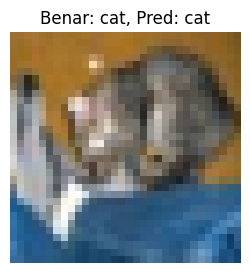

Feature maps untuk gambar benar #1 (Pred: cat | True: cat):


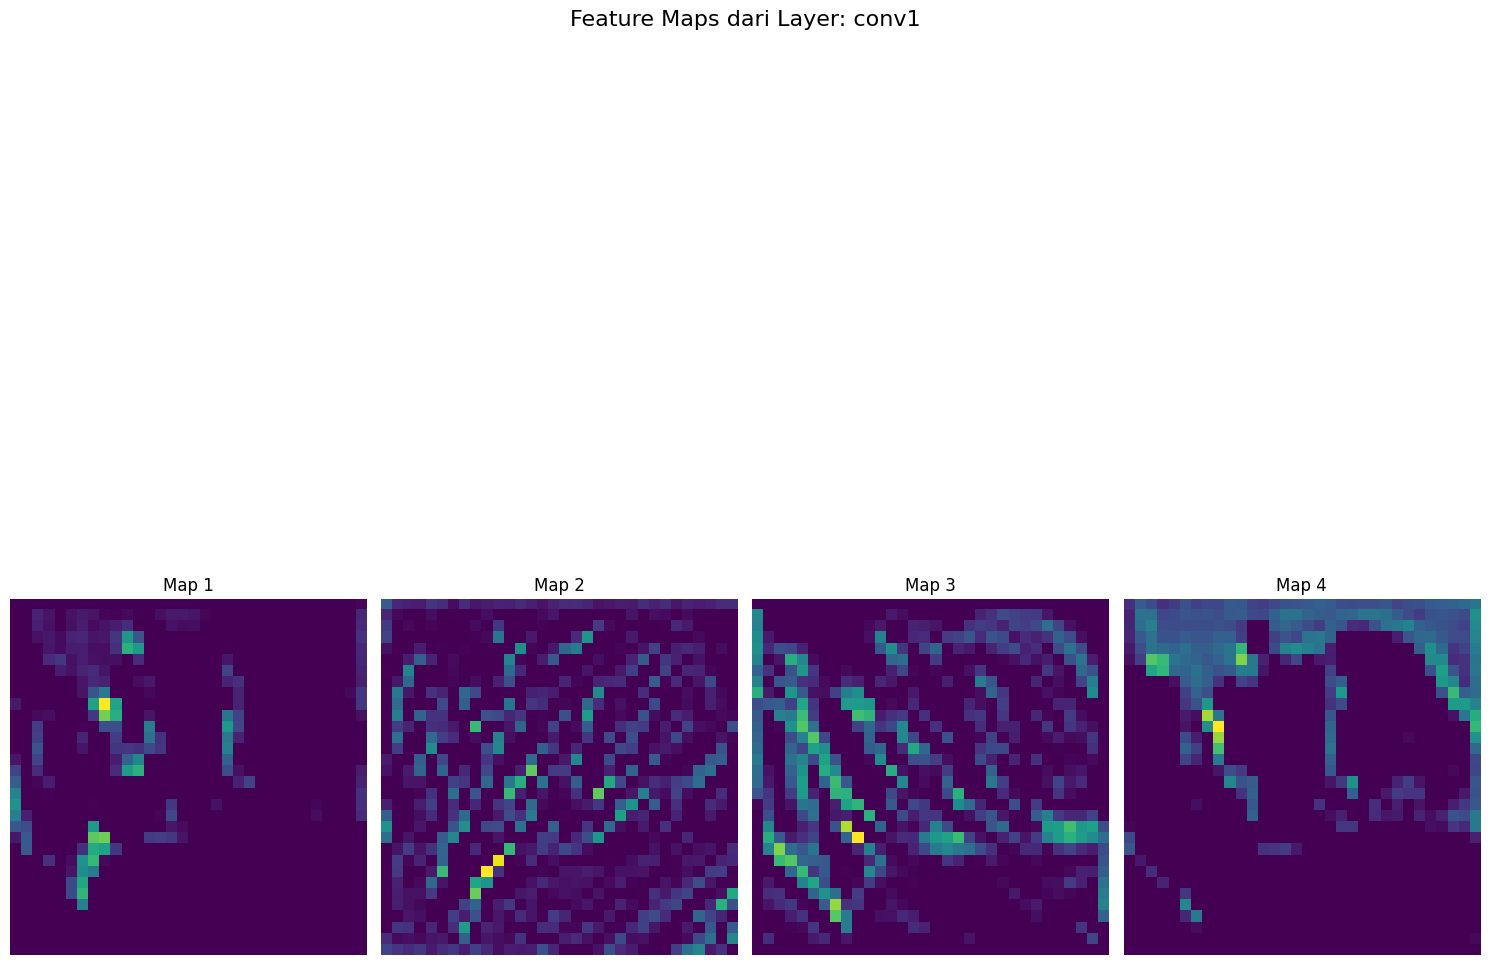

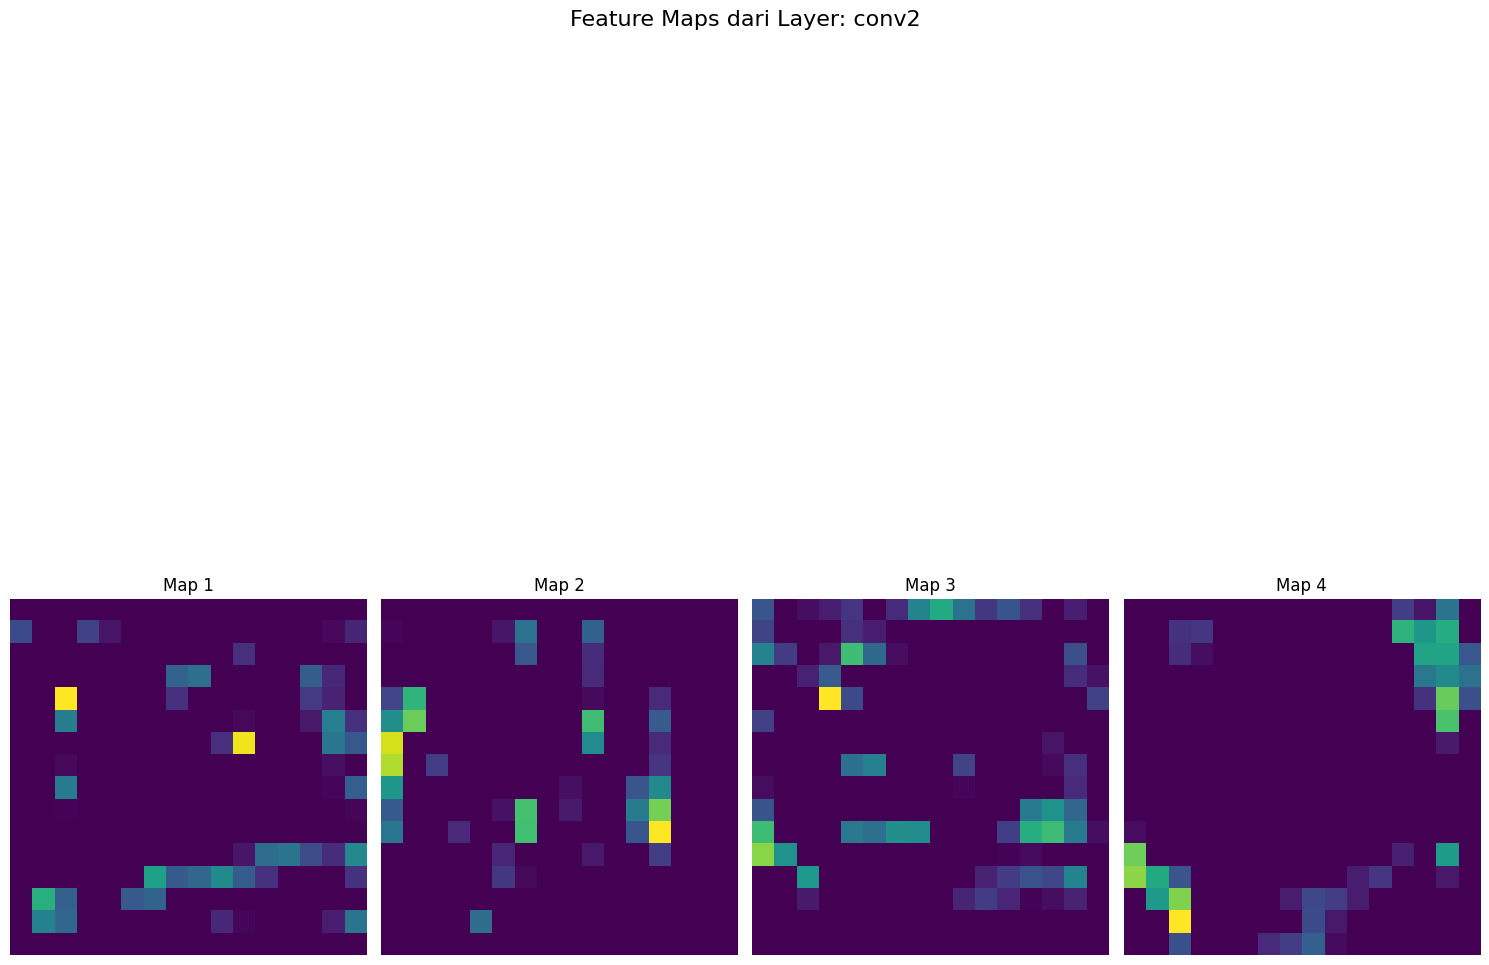

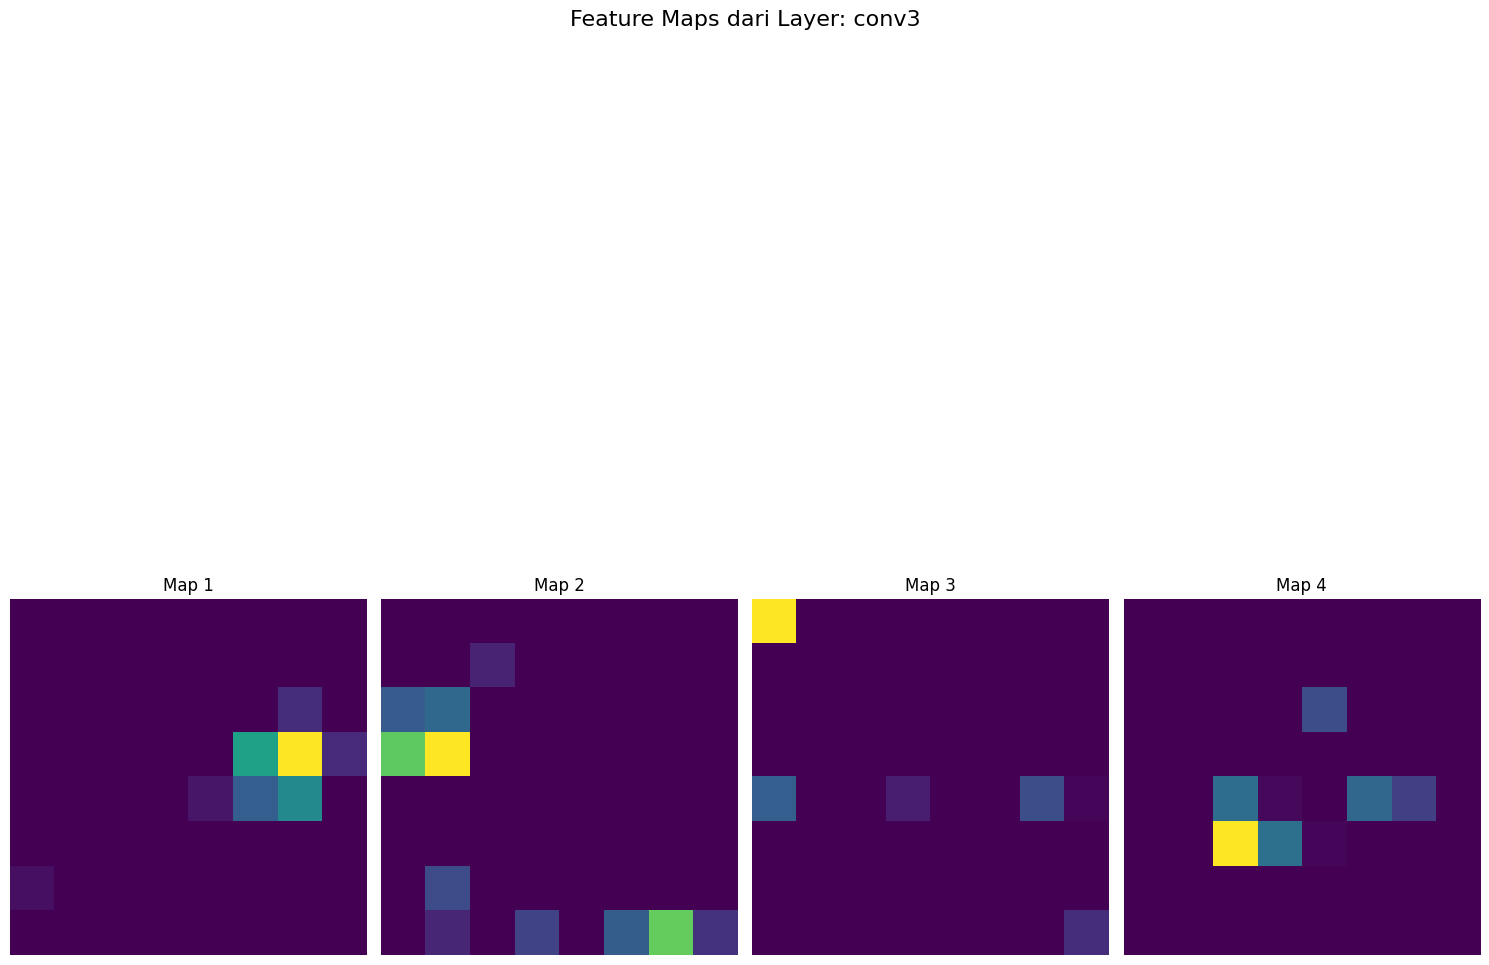


Gambar Benar #2:


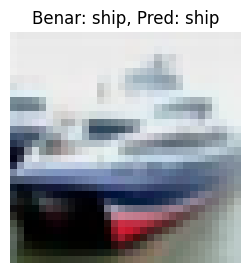

Feature maps untuk gambar benar #2 (Pred: ship | True: ship):


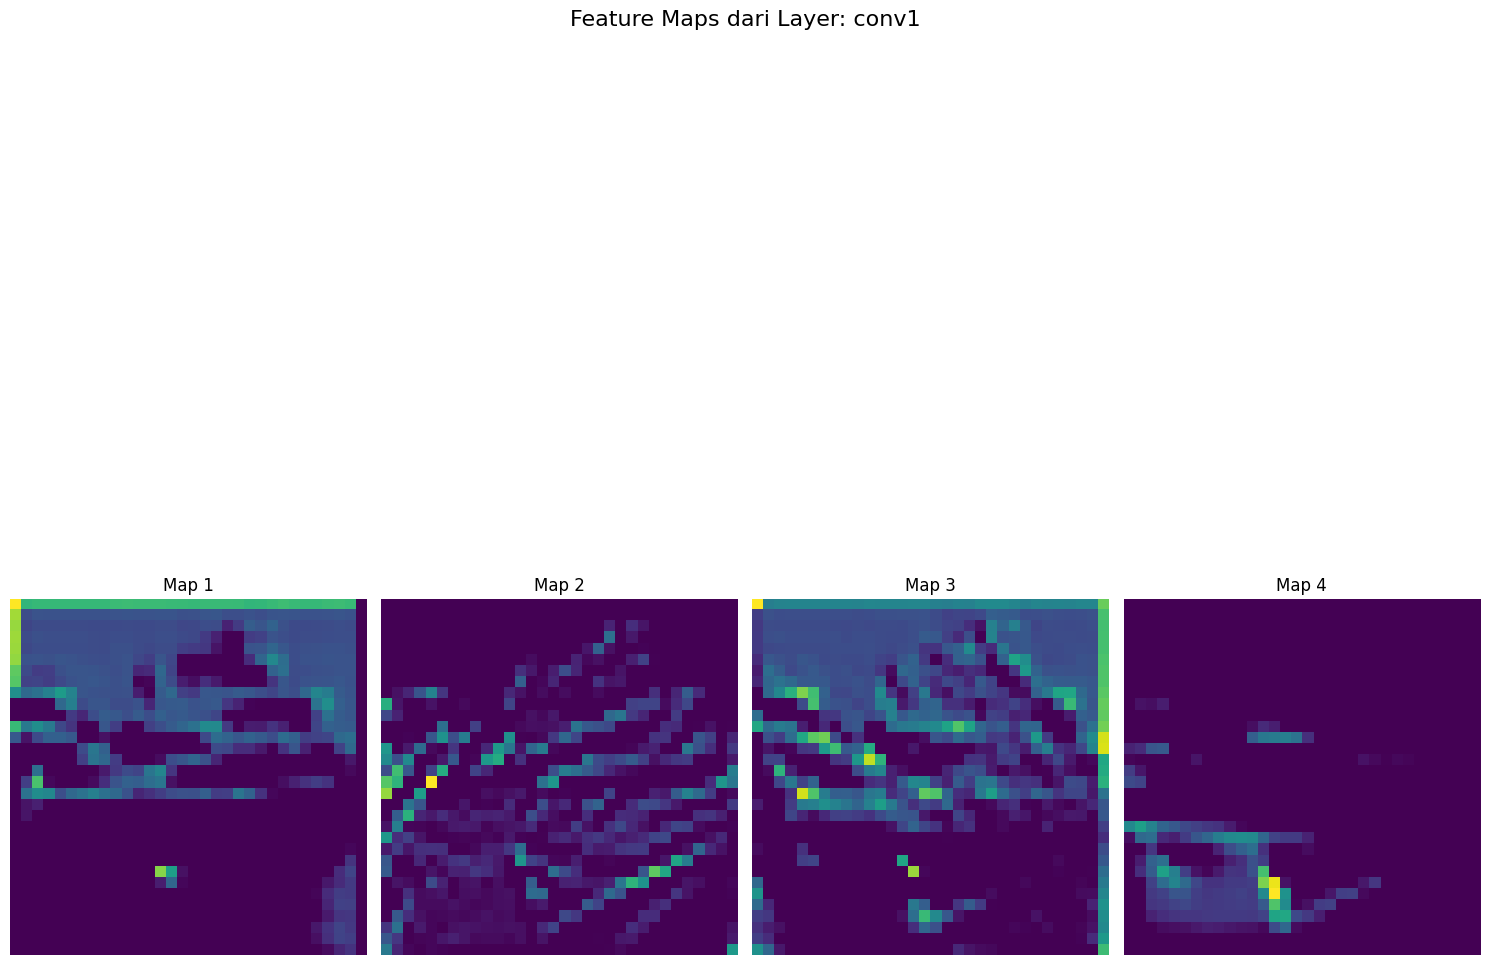

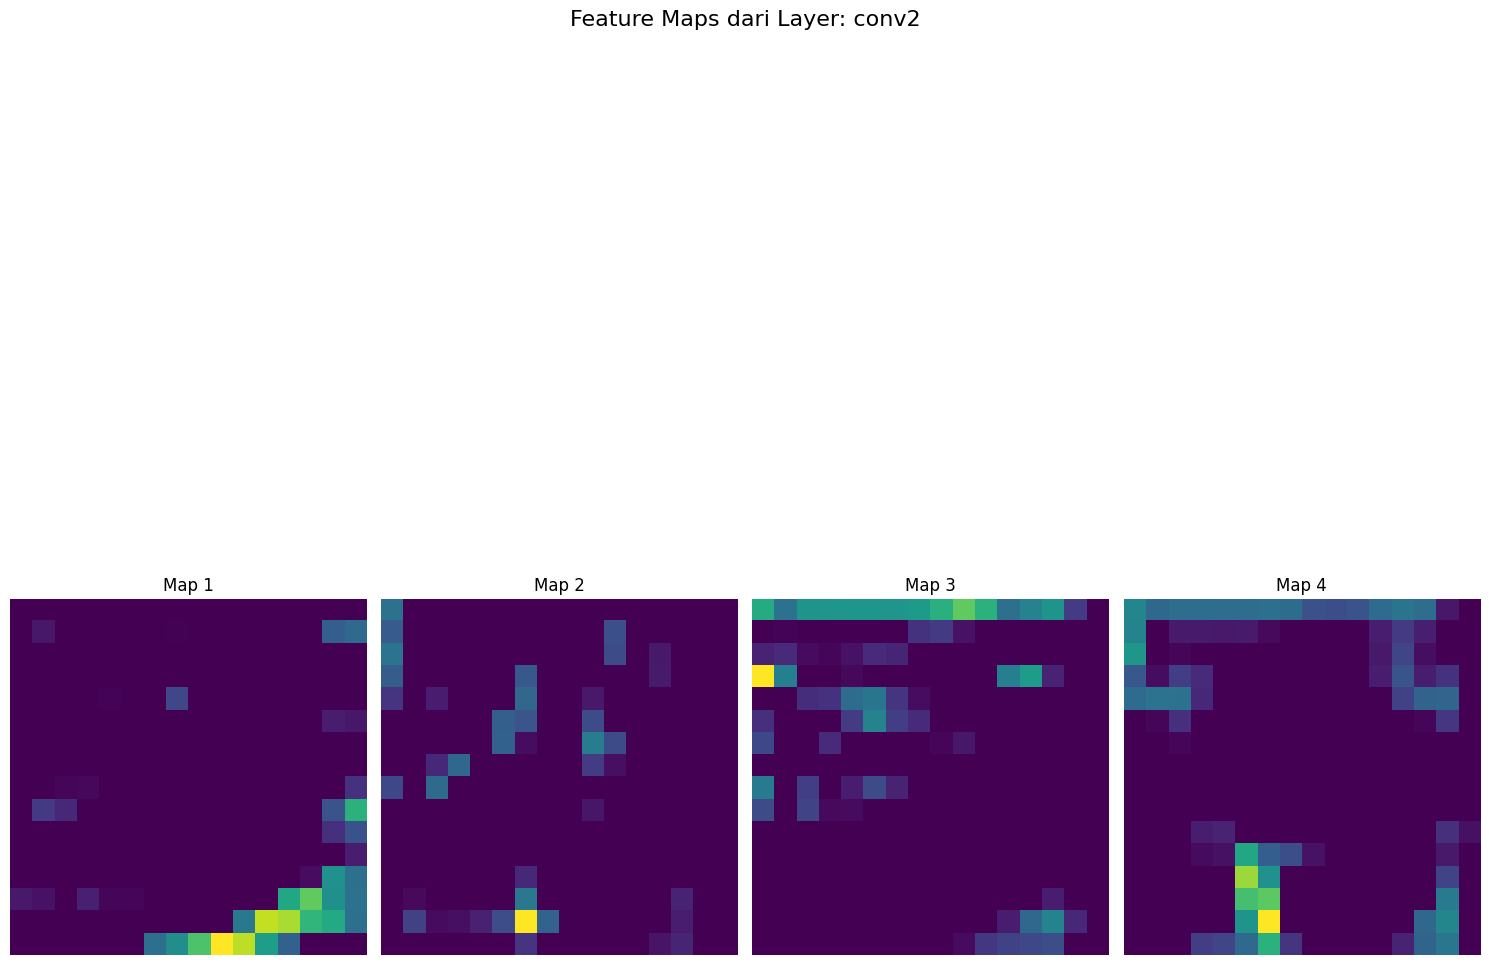

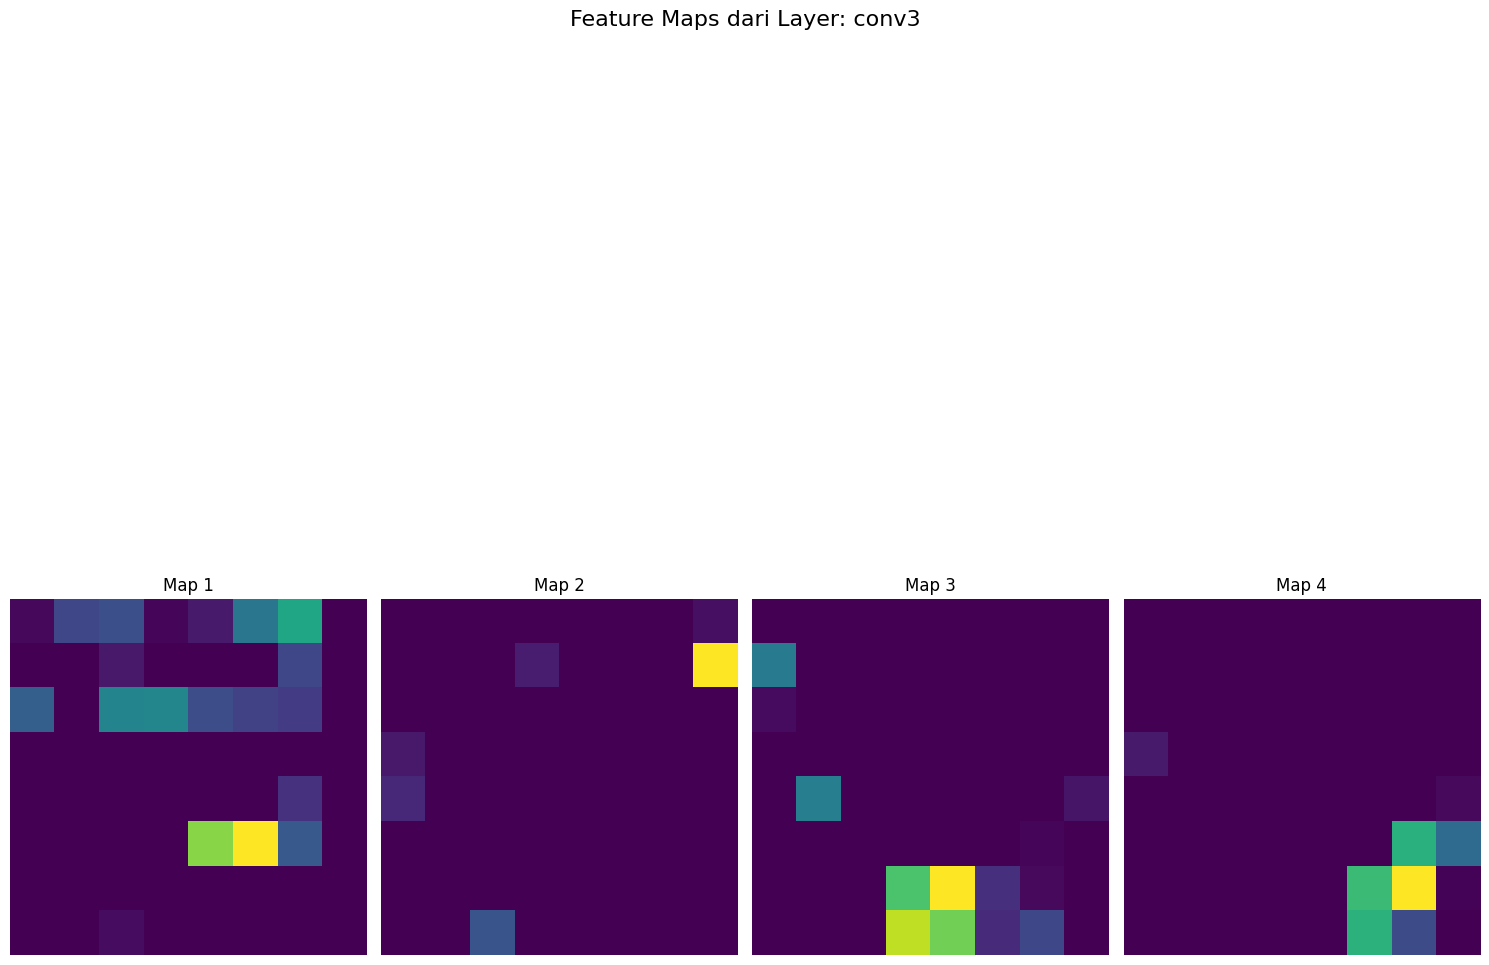


--- Prediksi Salah (Detail Feature Maps) ---

Gambar Salah #1:


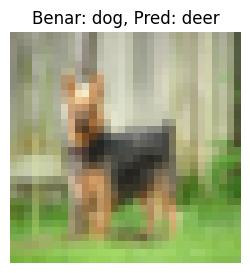

Feature maps untuk gambar salah #1 (Pred: deer | True: dog):


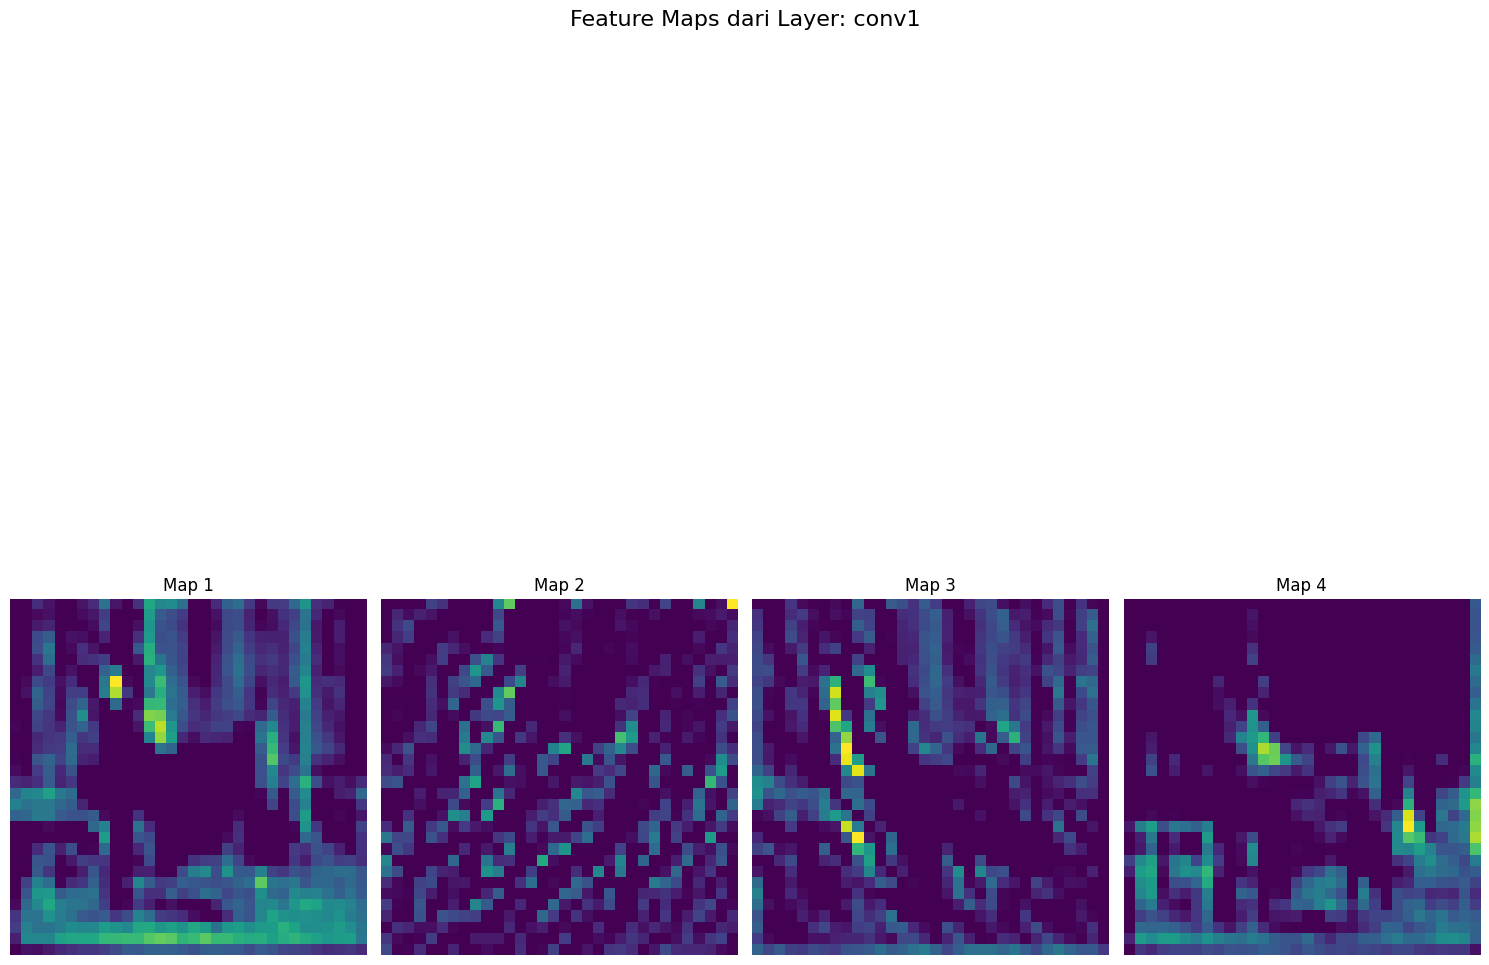

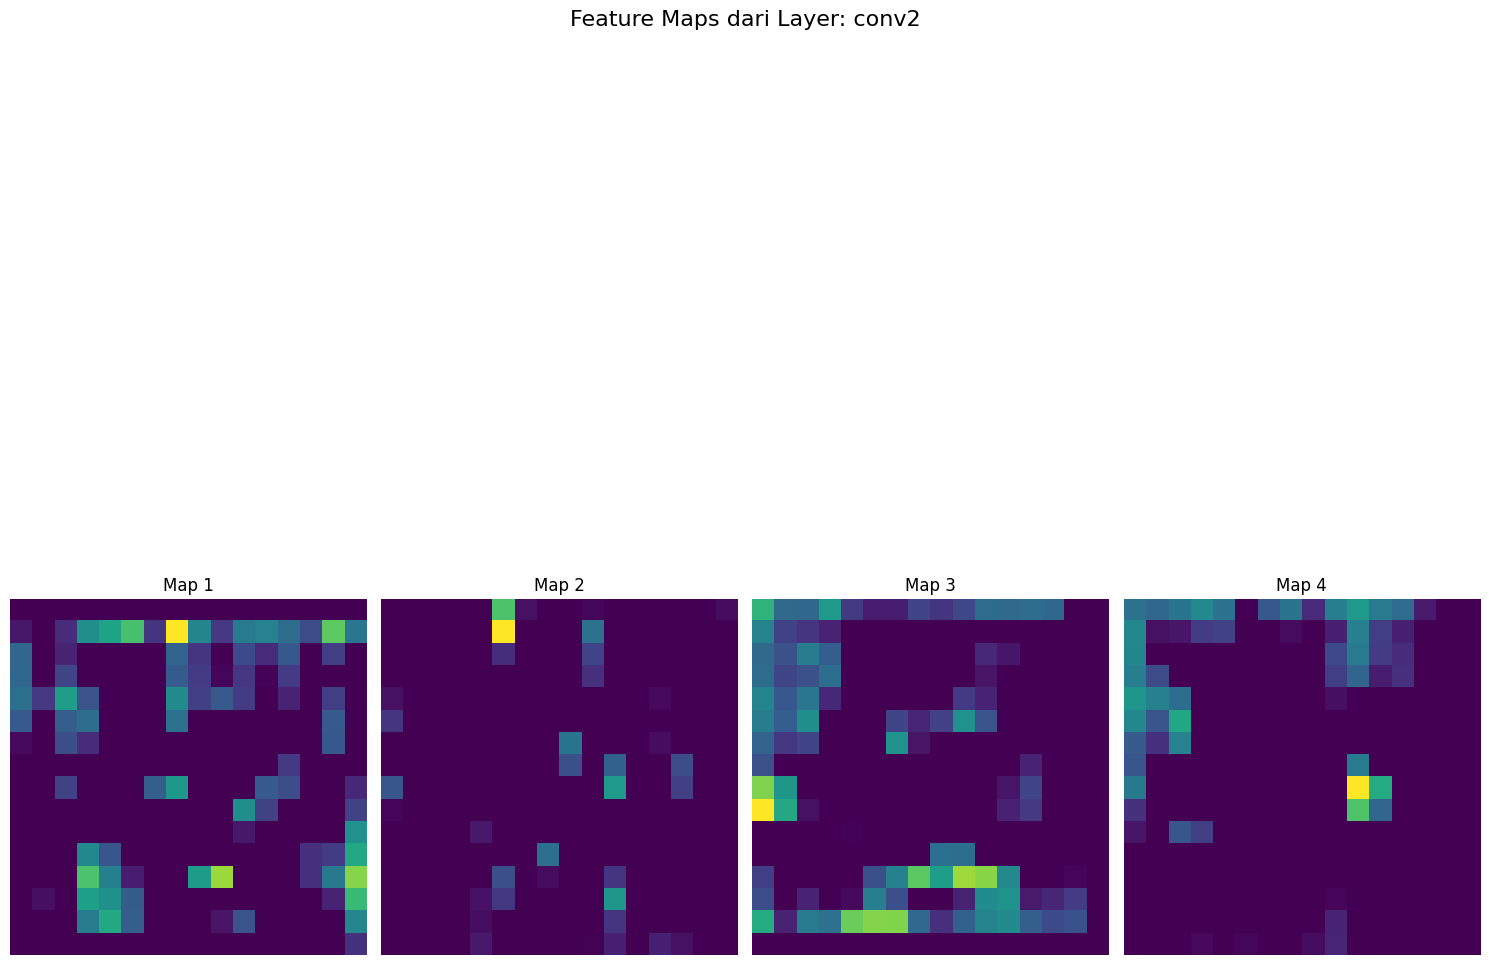

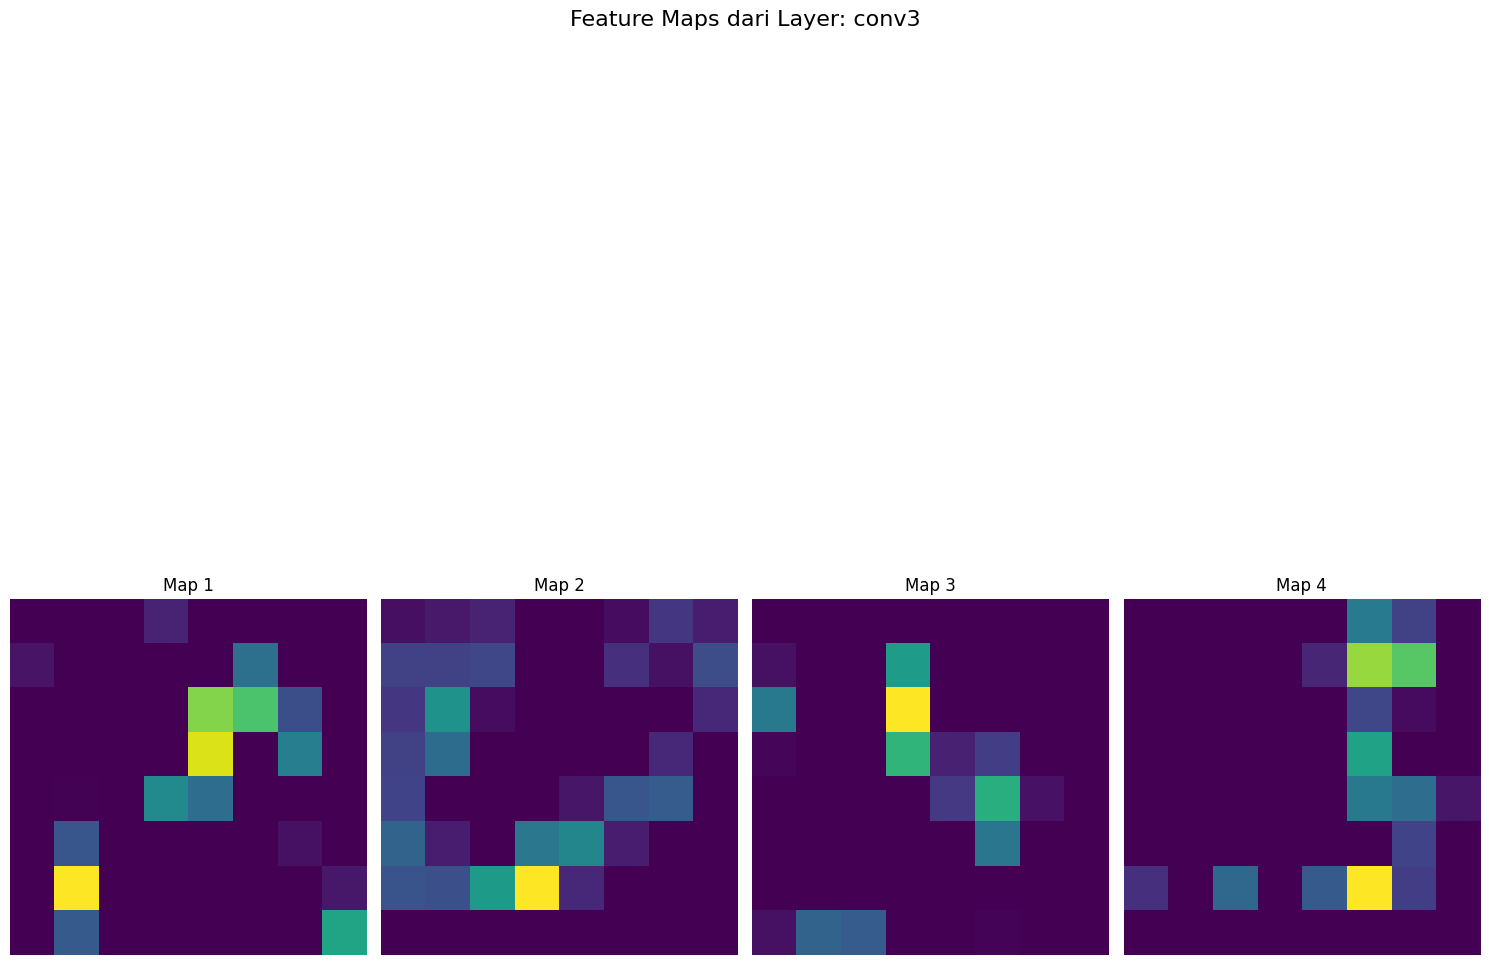


Gambar Salah #2:


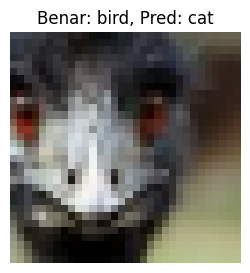

Feature maps untuk gambar salah #2 (Pred: cat | True: bird):


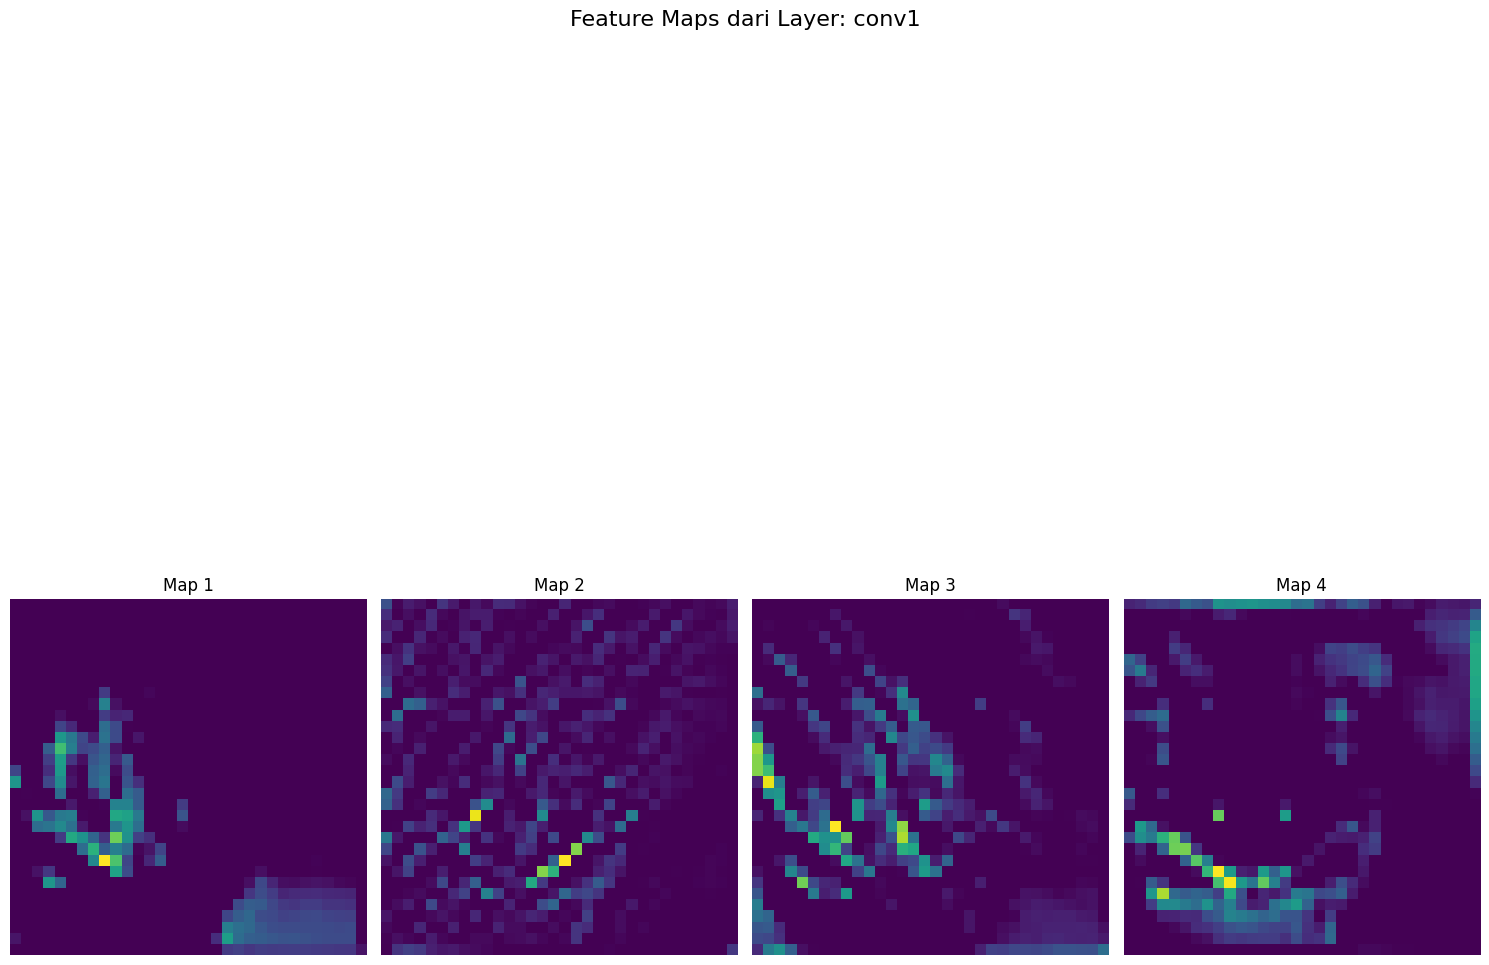

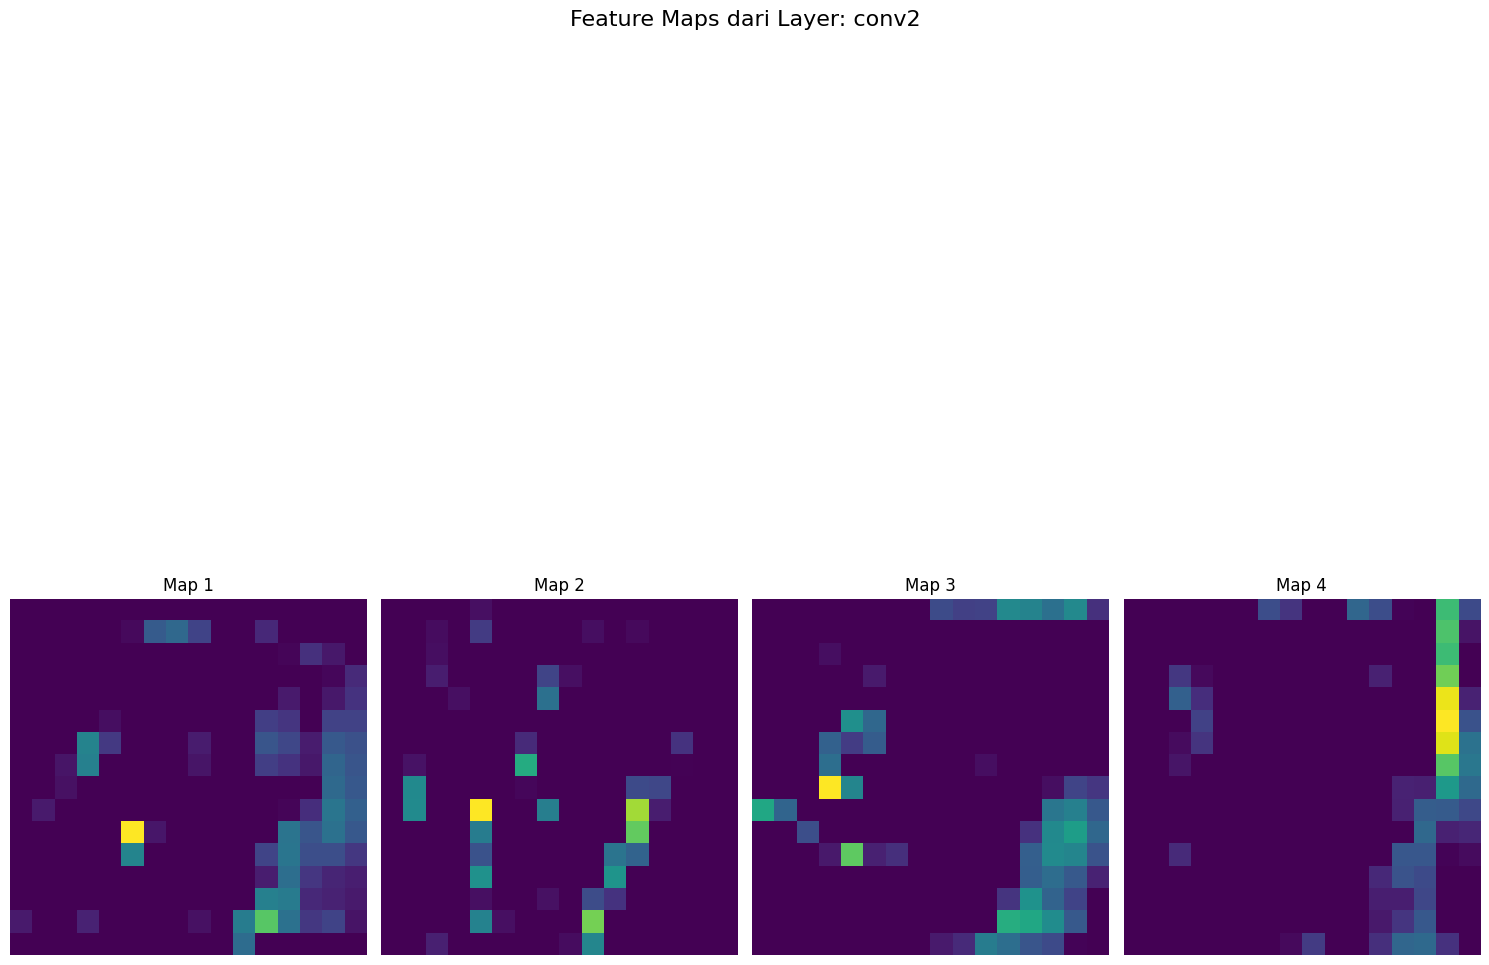

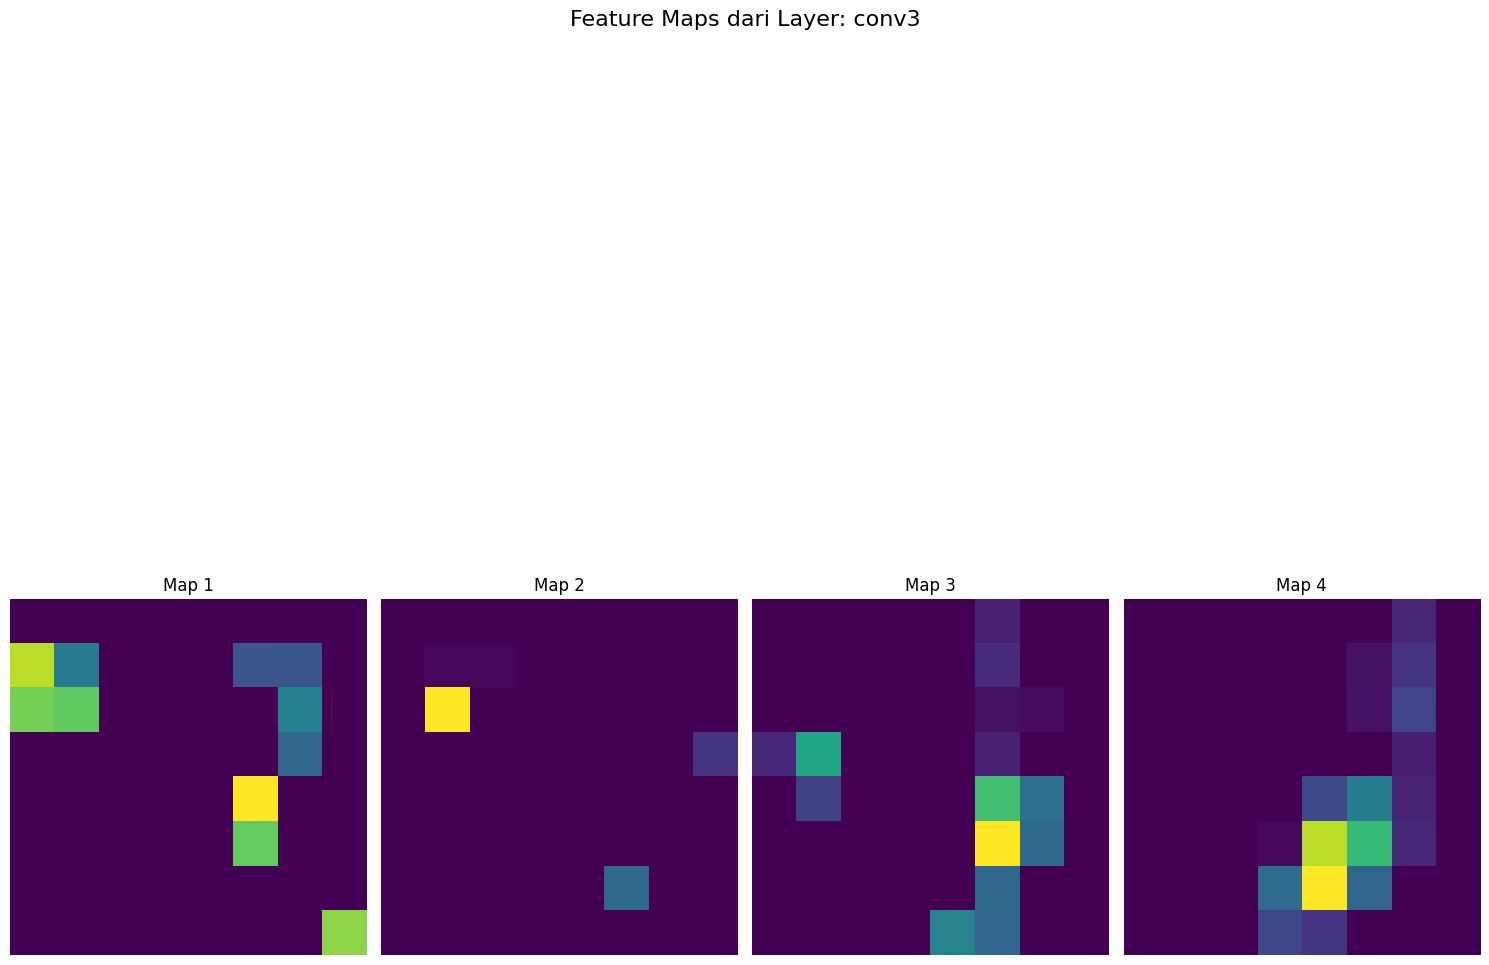

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader

# --- Asumsi variabel berikut sudah ada dari sel-sel sebelumnya:
# model_fm: model terbaik (CIFAR10NetWithFeatureMaps) yang sudah di-load dan .eval()
#           (Ini adalah model_fm dari sel "Analisis Feature Maps pada Kesalahan Prediksi")
# best_result: dictionary yang menyimpan hasil terbaik, termasuk konfigurasi
# device: perangkat (cpu atau gpu)
# testset: dataset tes CIFAR-10 yang sudah di-transform
# classes: tuple/list nama kelas ('plane', 'car', ...)
# imshow: fungsi untuk menampilkan gambar tensor (sudah ada di sel Evaluasi Rinci)
# visualize_feature_maps: fungsi untuk menampilkan feature maps (sudah ada di sel Definisi Model)

# --- Tingkatkan DPI untuk visualisasi lebih tajam (opsional, jika belum diatur) ---
plt.rcParams['figure.dpi'] = 100 # kita bisa sesuaikan nilainya, 150 seperti di contoh kita

# --- Pastikan model_fm dan testloader_final ada dan siap ---
if 'model_fm' not in locals() or 'best_result' not in locals():
    print("Variabel 'model_fm' atau 'best_result' tidak ditemukan.")
    print("Pastikan sel 'Analisis Feature Maps pada Kesalahan Prediksi' atau sel training sudah dijalankan.")
    # kita mungkin perlu memuat ulang model terbaik di sini jika variabel tidak ada
    # Contoh:
    # print(f"Memuat model terbaik dari {best_model_path}...")
    # best_config_viz = best_result['config']
    # model_fm = CIFAR10NetWithFeatureMaps(best_config_viz)
    # model_fm.load_state_dict(torch.load(best_model_path))
    # model_fm.to(device)
    # model_fm.eval()
else:
    model_fm.eval() # Pastikan model dalam mode evaluasi

# --- Membuat DataLoader dengan batch size terbaik (jika belum ada testloader_final) ---
if 'testloader_final' not in locals():
    if 'best_result' in locals():
        best_batch_size_viz = best_result['config'].get('batch_size', 128)
        testloader_final = DataLoader(testset, batch_size=best_batch_size_viz, shuffle=False, num_workers=2)
    else:
        print("Konfigurasi batch size terbaik tidak ditemukan untuk membuat testloader_final.")
        testloader_final = None

# --- Mengambil batch dari testloader ---
if testloader_final:
    dataiter_viz_detailed = iter(testloader_final)
    try:
        images_detailed, labels_detailed = next(dataiter_viz_detailed)
    except StopIteration:
        print("Test loader visualisasi detail kosong.")
        images_detailed, labels_detailed = None, None
else:
    images_detailed, labels_detailed = None, None

if images_detailed is not None:
    images_to_device_detailed = images_detailed.to(device)
    labels_to_device_detailed = labels_detailed.to(device)

    with torch.no_grad():
        outputs_detailed, feature_maps_from_model = model_fm(images_to_device_detailed)
        _, predicted_detailed = torch.max(outputs_detailed, 1)

    predicted_detailed = predicted_detailed.cpu()
    labels_detailed = labels_detailed.cpu()
    # feature_maps_from_model sudah merupakan dictionary dari feature maps per layer konvolusi dari model kita

    # --- Memisahkan gambar yang diprediksi benar dan salah ---
    correct_idx_detailed = (predicted_detailed == labels_detailed).nonzero(as_tuple=True)[0]
    incorrect_idx_detailed = (predicted_detailed != labels_detailed).nonzero(as_tuple=True)[0]

    # --- Menampilkan gambar dan feature maps untuk prediksi benar (maksimal 2) ---
    if len(correct_idx_detailed) > 0:
        print("\n--- Prediksi Benar (Detail Feature Maps) ---")
        for i, idx in enumerate(correct_idx_detailed[:2]): # Ambil 2 contoh pertama yang benar
            img_tensor = images_detailed[idx]

            print(f"\nGambar Benar #{i+1}:")
            # Tampilkan gambar input
            plt.figure(figsize=(3,3))
            imshow(img_tensor.cpu()) # imshow dari sel sebelumnya
            plt.title(f'Benar: {classes[labels_detailed[idx].item()]}, Pred: {classes[predicted_detailed[idx].item()]}')
            plt.show()

            # Dapatkan feature maps untuk gambar spesifik ini
            with torch.no_grad():
                _, specific_feature_maps = model_fm(img_tensor.unsqueeze(0).to(device))

            print(f"Feature maps untuk gambar benar #{i+1} (Pred: {classes[predicted_detailed[idx].item()]} | True: {classes[labels_detailed[idx].item()]}):")
            visualize_feature_maps(specific_feature_maps, num_maps_to_show=4) # visualize_feature_maps dari sel sebelumnya, tampilkan 4 filter

    else:
        print("\nTidak ada prediksi benar di batch ini untuk ditampilkan.")

    # --- Menampilkan gambar dan feature maps untuk prediksi salah (maksimal 2) ---
    if len(incorrect_idx_detailed) > 0:
        print("\n--- Prediksi Salah (Detail Feature Maps) ---")
        for i, idx in enumerate(incorrect_idx_detailed[:2]): # Ambil 2 contoh pertama yang salah
            img_tensor = images_detailed[idx]

            print(f"\nGambar Salah #{i+1}:")
            # Tampilkan gambar input
            plt.figure(figsize=(3,3))
            imshow(img_tensor.cpu()) # imshow dari sel sebelumnya
            plt.title(f'Benar: {classes[labels_detailed[idx].item()]}, Pred: {classes[predicted_detailed[idx].item()]}')
            plt.show()

            # Dapatkan feature maps untuk gambar spesifik ini
            with torch.no_grad():
                _, specific_feature_maps = model_fm(img_tensor.unsqueeze(0).to(device))

            print(f"Feature maps untuk gambar salah #{i+1} (Pred: {classes[predicted_detailed[idx].item()]} | True: {classes[labels_detailed[idx].item()]}):")
            visualize_feature_maps(specific_feature_maps, num_maps_to_show=4) # visualize_feature_maps dari sel sebelumnya, tampilkan 4 filter

    else:
        print("\nTidak ada prediksi salah di batch ini untuk ditampilkan.")
else:
    print("Tidak ada data untuk divisualisasikan secara detail.")

### **INTERPRETASI HASIL:**

### **APA YANG DILIHAT MODEL DI SETIAP LAPISAN:**

### Lapisan Awal (conv1)

* **Yang Kelihatan:**
    * Di sini, model baru mulai "melihat" garis-garis pinggir dan tekstur kasar di gambar.
    * Kelihatan ada pola-pola miring, lurus, dan beberapa area yang warnanya lebih terang (kuning), terutama di sekitar badan kucing dan juga di latarnya.
* **Maksudnya Apa:**
    * Lapisan `conv1` ini tugasnya menangkap **detail-detail dasar** kayak tepi objek, bercak warna, atau bentuk kasarnya.
    * Bayangkan filter di sini kayak alat deteksi sederhana yang membedakan mana area terang dan mana yang gelap.
    * Area yang "menyala" itu kemungkinan besar adalah bentuk telinga, garis muka, atau perbedaan warna antara bulu kucing dan background-nya.

---

### Lapisan Tengah (conv2)

* **Yang Kelihatan:**
    * Polanya sekarang jadi lebih **terkotak-kotak** dan nggak acak kayak di lapisan pertama. Ukurannya juga jadi lebih kecil.
    * Area yang terang sekarang cuma di beberapa bagian tertentu saja, nggak menyebar.
    * Cenderung membentuk blok-blok atau kotak-kotak kecil.
* **Maksudnya Apa:**
    * Lapisan `conv2` ini mulai **merangkai detail-detail dasar tadi jadi bentuk yang lebih punya arti**, misalnya bagian tubuh atau ciri khas objek.
    * Area yang aktif sekarang mungkin mewakili hal penting kayak mata, pola garis di badan kucing, atau bentuk kupingnya tapi secara lebih umum.
    * Ini tandanya model mulai "paham" kalau bagian-bagian kecil tadi kalau digabung bisa jadi bentuk kucing, bukan cuma sekadar garis acak.

---

### Lapisan Dalam (conv3)

* **Yang Kelihatan:**
    * Sekarang, area yang "menyala" **sangat sedikit dan fokus banget** di titik tertentu.
    * Sebagian besar gambarnya gelap, artinya model sudah sangat pilih-pilih mana yang penting.
    * Tiap peta fitur cuma fokus ke satu area kecil yang sangat spesifik.
* **Maksudnya Apa:**
    * Lapisan `conv3` ini menangkap **ciri-ciri paling penting dan unik** yang khas untuk kelas objek itu (di sini, ya "kucing").
    * Area yang aktif itu bisa jadi adalah pola visual yang cuma ada di kucing, misalnya bentuk matanya yang khas, struktur mukanya, atau corak bulu tertentu.
    * Di tahap ini, model sudah menyaring habis info yang nggak penting dan cuma mempertahankan ciri-ciri yang paling menentukan kalau itu kucing.

---

### **Intinya:**

* Cara kerja CNN dalam mengenali gambar itu **bertingkat**: mulai dari deteksi garis-garis dasar (di conv1), lalu membentuk struktur yang lebih berarti (di conv2), sampai akhirnya mengenali ciri khas objek (di conv3).
* Semakin dalam lapisannya, area yang aktif jadi makin fokus dan pilih-pilih. Ini menunjukkan kalau modelnya **mulai bisa mengenali pola utama** meskipun ada variasi warna, sudut pandang, atau gangguan di gambar.
* Informasi dari lapisan `conv3` inilah yang paling berguna untuk menentukan ini gambar apa, karena semua yang nggak relevan sudah dibuang.

## **Visualisasi Confusion Matrix**


Mengumpulkan prediksi untuk confusion matrix...


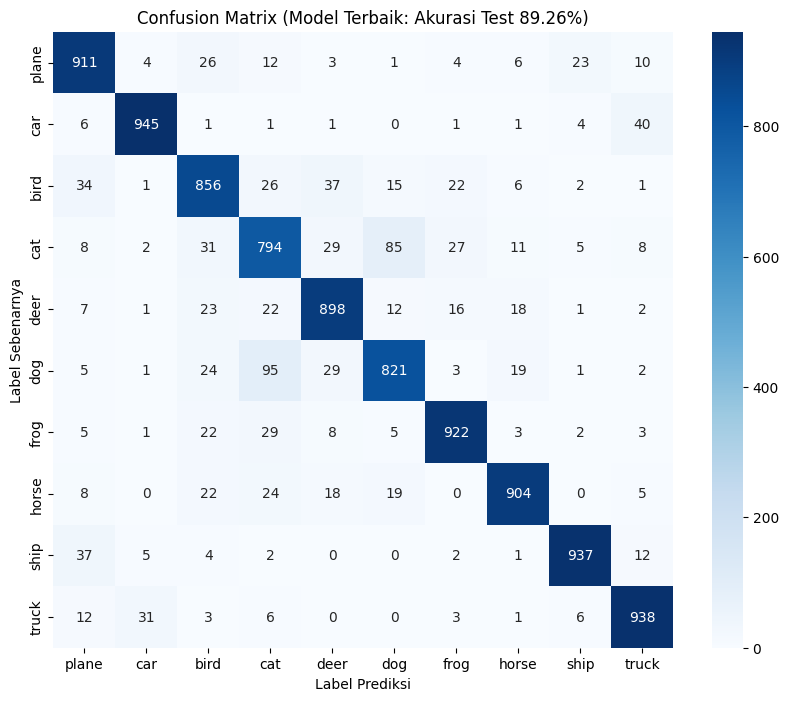


--- Analisis Tambahan dari Confusion Matrix (Contoh) ---
Kelas plane     :
  Precision: 0.88
  Recall   : 0.91
Kelas car       :
  Precision: 0.95
  Recall   : 0.94
Kelas bird      :
  Precision: 0.85
  Recall   : 0.86
Kelas cat       :
  Precision: 0.79
  Recall   : 0.79
Kelas deer      :
  Precision: 0.88
  Recall   : 0.90
Kelas dog       :
  Precision: 0.86
  Recall   : 0.82
Kelas frog      :
  Precision: 0.92
  Recall   : 0.92
Kelas horse     :
  Precision: 0.93
  Recall   : 0.90
Kelas ship      :
  Precision: 0.96
  Recall   : 0.94
Kelas truck     :
  Precision: 0.92
  Recall   : 0.94


In [ ]:
from sklearn.metrics import confusion_matrix # Mengimpor fungsi confusion_matrix dari scikit-learn untuk menghitung matriks kebingungan
import seaborn as sns # Mengimpor library seaborn untuk visualisasi data statistik yang lebih menarik, termasuk heatmap
import pandas as pd # Mengimpor library pandas untuk manipulasi dan analisis data, terutama untuk membuat DataFrame

# --- Kumpulkan Semua Prediksi dan Label Sebenarnya dari Test Set ---
all_labels_true = [] # Inisialisasi list kosong untuk menyimpan semua label sebenarnya dari dataset tes
all_labels_pred = [] # Inisialisasi list kosong untuk menyimpan semua label prediksi dari model untuk dataset tes

# Gunakan model_to_eval yang sudah dilatih dan dimuat dari sel evaluasi rinci
# atau muat kembali jika belum ada
if 'model_to_eval' not in locals(): # Memeriksa apakah variabel 'model_to_eval' sudah terdefinisi di lingkup lokal
    print(f"Memuat kembali model terbaik dari {best_model_path} untuk confusion matrix...") # Pesan informasi jika model perlu dimuat ulang
    best_config_cm = best_result['config'] # Mengambil konfigurasi model terbaik (diasumsikan 'best_result' sudah ada)
    model_to_eval = CIFAR10NetWithFeatureMaps(best_config_cm) # Membuat instance model. Dicatat bahwa ini menggunakan CIFAR10NetWithFeatureMaps
    model_to_eval.load_state_dict(torch.load(best_model_path)) # Memuat bobot model yang telah dilatih dari 'best_model_path'
    model_to_eval.to(device) # Memindahkan model ke perangkat (CPU/GPU) yang ditentukan oleh 'device'
    model_to_eval.eval() # Mengatur model ke mode evaluasi (penting untuk batchnorm dan dropout)

# Pastikan testloader_final sudah ada
if 'testloader_final' not in locals(): # Memeriksa apakah 'testloader_final' sudah terdefinisi
     best_batch_size_cm = best_result['config'].get('batch_size', 128) # Mengambil ukuran batch dari konfigurasi, default 128
     testloader_final = DataLoader(testset, batch_size=best_batch_size_cm, shuffle=False, num_workers=2) # Membuat DataLoader untuk test set jika belum ada. shuffle=False untuk konsistensi

print("\nMengumpulkan prediksi untuk confusion matrix...") # Pesan informasi proses pengumpulan prediksi
with torch.no_grad(): # Blok konteks untuk menonaktifkan perhitungan gradien selama inferensi
    for images_batch, labels_batch in testloader_final: # Iterasi melalui setiap batch dalam testloader_final
        images_batch_device = images_batch.to(device) # Memindahkan batch gambar ke perangkat
        labels_batch_device = labels_batch.to(device) # Memindahkan batch label ke perangkat

        outputs, _ = model_to_eval(images_batch_device) # Melakukan forward pass. Model mengembalikan (logits, feature_maps), feature_maps diabaikan '_'
        _, predicted_batch = torch.max(outputs, 1) # Mendapatkan prediksi kelas dengan mengambil indeks dari nilai output maksimum pada dimensi 1 (dimensi kelas)

        all_labels_true.extend(labels_batch_device.cpu().numpy()) # Menambahkan label sebenarnya dari batch saat ini ke list all_labels_true. Pindahkan ke CPU dan konversi ke array NumPy dulu.
        all_labels_pred.extend(predicted_batch.cpu().numpy()) # Menambahkan label prediksi dari batch saat ini ke list all_labels_pred. Pindahkan ke CPU dan konversi ke array NumPy.

# --- Hitung Confusion Matrix ---
cm = confusion_matrix(all_labels_true, all_labels_pred) # Menghitung confusion matrix menggunakan label sebenarnya dan label prediksi
cm_df = pd.DataFrame(cm, index=classes, columns=classes) # Membuat Pandas DataFrame dari confusion matrix untuk visualisasi yang lebih baik, dengan nama kelas sebagai indeks dan kolom

# --- Visualisasi Confusion Matrix ---
plt.figure(figsize=(10, 8)) # Membuat figure Matplotlib baru dengan ukuran 10x8 inci
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues') # Membuat heatmap menggunakan seaborn.
                                                      # annot=True: menampilkan nilai dalam setiap sel heatmap.
                                                      # fmt='d': format angka dalam sel sebagai integer desimal.
                                                      # cmap='Blues': menggunakan skema warna biru.
plt.title(f'Confusion Matrix (Model Terbaik: Akurasi Test {best_result["final_test_accuracy"]:.2f}%)') # Memberikan judul pada plot, termasuk akurasi tes model
plt.ylabel('Label Sebenarnya') # Memberikan label pada sumbu y
plt.xlabel('Label Prediksi') # Memberikan label pada sumbu x
plt.show() # Menampilkan plot confusion matrix

print("\n--- Analisis Tambahan dari Confusion Matrix (Contoh) ---") # Header untuk analisis tambahan
for i in range(len(classes)): # Iterasi melalui setiap kelas (berdasarkan jumlah kelas yang ada)
    true_positives = cm[i, i] # True Positives (TP): elemen diagonal dari confusion matrix untuk kelas ke-i
    false_positives = cm[:, i].sum() - true_positives # False Positives (FP): jumlah total prediksi untuk kelas i, dikurangi TP. Ini adalah jumlah item dari kelas lain yang salah diprediksi sebagai kelas i.
    false_negatives = cm[i, :].sum() - true_positives # False Negatives (FN): jumlah total item sebenarnya dari kelas i, dikurangi TP. Ini adalah jumlah item dari kelas i yang salah diprediksi sebagai kelas lain.

    # Menghitung Precision: TP / (TP + FP)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0 # Hindari pembagian dengan nol
    # Menghitung Recall (Sensitivity): TP / (TP + FN)
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0 # Hindari pembagian dengan nol

    print(f"Kelas {classes[i]:<10s}:") # Mencetak nama kelas (diformat agar lebar minimal 10 karakter, rata kiri)
    print(f"  Precision: {precision:.2f}") # Mencetak nilai precision dengan 2 angka desimal
    print(f"  Recall   : {recall:.2f}") # Mencetak nilai recall dengan 2 angka desimal

### **INTERPRETASI HASIL:**


* **Kelas plane**
  Yang benar-benar **plane**, model berhasil menemukan **91%** di antaranya (recall 91%), dan dari semua yang diprediksi sebagai plane, **88%** memang benar plane (precision 88%).

* **Kelas car**
  Yang benar-benar **car**, model berhasil menemukan **94%** (recall 94%), dan dari semua yang diprediksi sebagai car, **95%** memang benar car (precision 95%).

* **Kelas bird**
  Yang benar-benar **bird**, model berhasil menemukan **86%** (recall 86%), dan dari semua yang diprediksi sebagai bird, **85%** memang benar bird (precision 85%).

* **Kelas cat**
  Yang benar-benar **cat**, model berhasil menemukan **79%** (recall 79%), dan dari semua yang diprediksi sebagai cat, **79%** memang benar cat (precision 79%).

* **Kelas deer**
  Yang benar-benar **deer**, model berhasil menemukan **90%** (recall 90%), dan dari semua yang diprediksi sebagai deer, **88%** memang benar deer (precision 88%).

* **Kelas dog**
  Yang benar-benar **dog**, model berhasil menemukan **82%** (recall 82%), dan dari semua yang diprediksi sebagai dog, **86%** memang benar dog (precision 86%).

* **Kelas frog**
  Yang benar-benar **frog**, model berhasil menemukan **92%** (recall 92%), dan dari semua yang diprediksi sebagai frog, **92%** memang benar frog (precision 92%).

* **Kelas horse**
  Yang benar-benar **horse**, model berhasil menemukan **90%** (recall 90%), dan dari semua yang diprediksi sebagai horse, **93%** memang benar horse (precision 93%).

* **Kelas ship**
  Yang benar-benar **ship**, model berhasil menemukan **94%** (recall 94%), dan dari semua yang diprediksi sebagai ship, **96%** memang benar ship (precision 96%).

* **Kelas truck**
  Yang benar-benar **truck**, model berhasil menemukan **94%** (recall 94%), dan dari semua yang diprediksi sebagai truck, **92%** memang benar truck (precision 92%).

---